# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Exploring Architectures](#GAN-vs-VAE)
3. [Generating Syntethic Data](#Conditional-Generative-Adversarial-Network)
4. [Syntethic VS Real](#Quality-assessment)
5. [Conclusion](#Conclusion)

## Libraries

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr, entropy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [2]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [4]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's deep dive into our real data.

In [5]:
utils.describe_data(real_iris, 'target')

REAL                     
                       setosa versicolor virginica
MEAN sepal length (cm)  5.006      5.936     6.588
     sepal width (cm)   3.428      2.770     2.974
     petal length (cm)  1.462      4.260     5.552
     petal width (cm)   0.246      1.326     2.026
STD  sepal length (cm)  0.352      0.516     0.636
     sepal width (cm)   0.379      0.314     0.322
     petal length (cm)  0.174      0.470     0.552
     petal width (cm)   0.105      0.198     0.275
MIN  sepal length (cm)  4.300      4.900     4.900
     sepal width (cm)   2.300      2.000     2.200
     petal length (cm)  1.000      3.000     4.500
     petal width (cm)   0.100      1.000     1.400
MAX  sepal length (cm)  5.800      7.000     7.900
     sepal width (cm)   4.400      3.400     3.800
     petal length (cm)  1.900      5.100     6.900
     petal width (cm)   0.600      1.800     2.500
SKEW sepal length (cm)  0.116      0.102     0.114
     sepal width (cm)   0.040     -0.352     0.355
     petal length (cm)  0.103     -0.588     0.533
     petal width (cm)   1.216     -0.030    -0.126
KURT sepal length (cm) -0.346     -0.599    -0.088
     sepal width (cm)   0.744     -0.448     0.520
     petal length (cm)  0.805     -0.074    -0.256
     petal width (cm)   1.434     -0.488    -0.661
IQR  sepal length (cm)  0.400      0.700     0.675
     sepal width (cm)   0.475      0.475     0.375
     petal length (cm)  0.175      0.600     0.775
     petal width (cm)   0.100      0.300     0.500

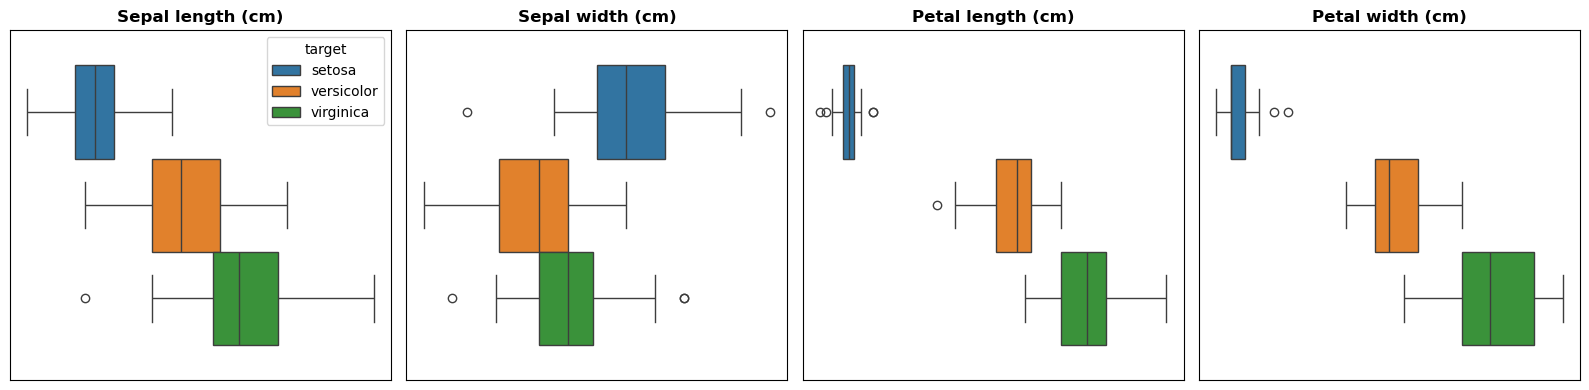

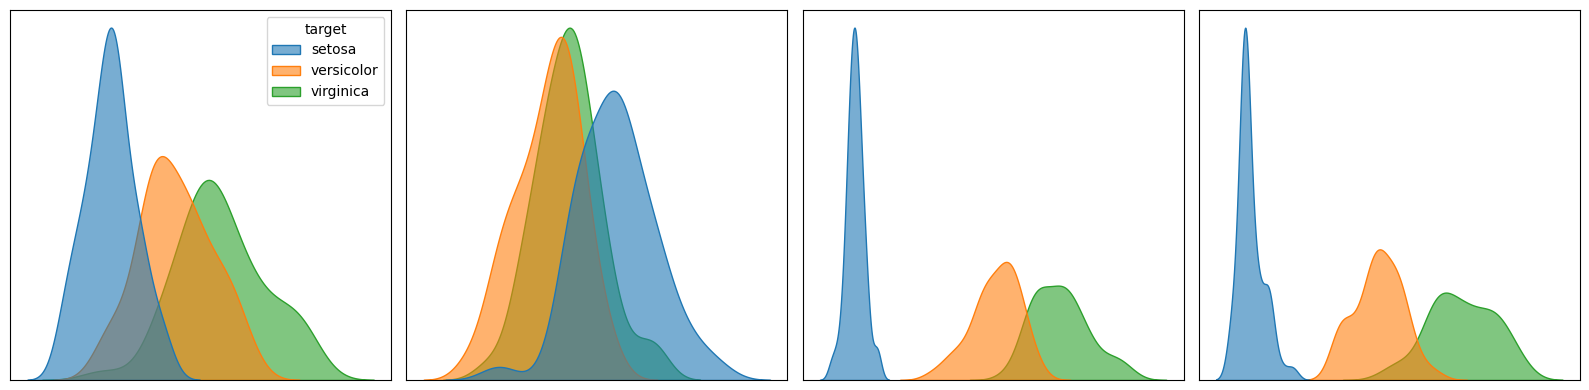

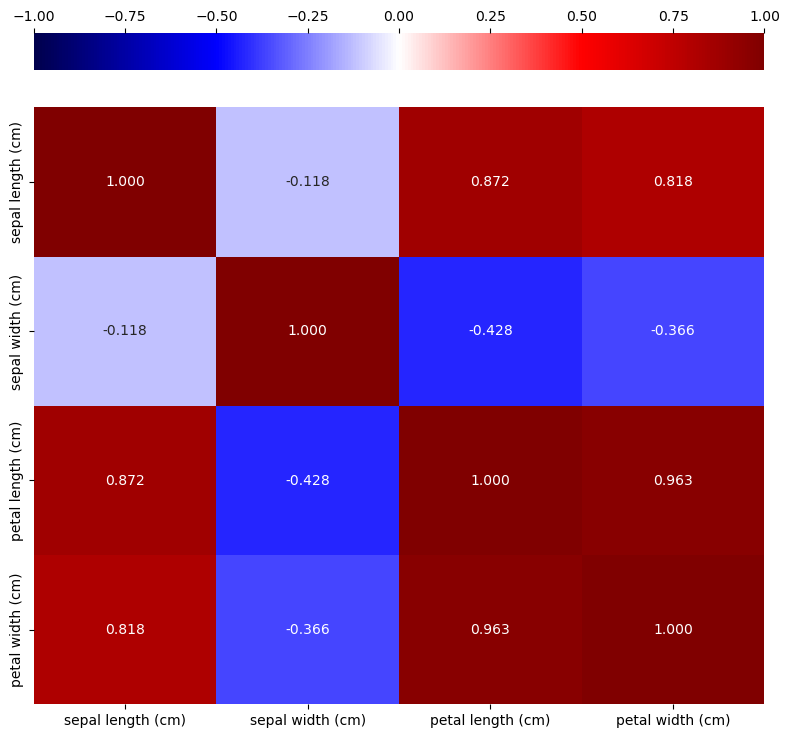

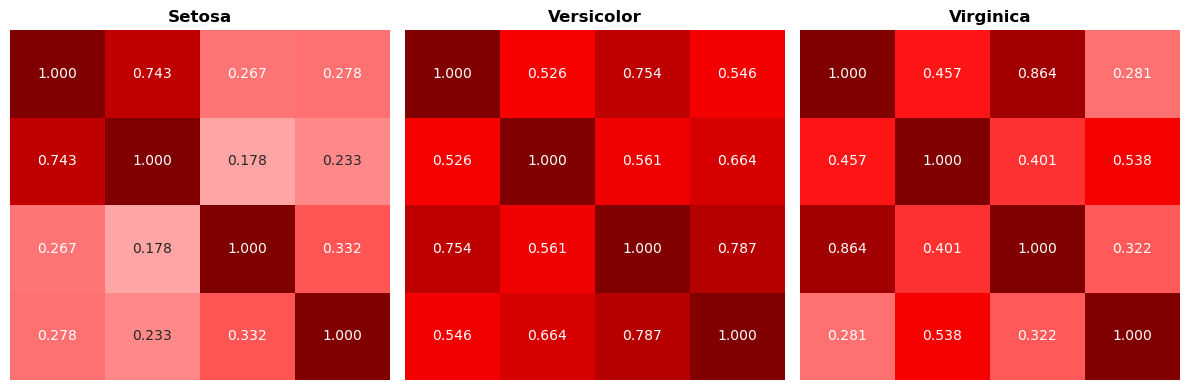

In [6]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,4.569346,3.870011,2.276723,1.337865,setosa
1,4.667597,2.690729,1.821865,0.142418,setosa
2,5.869346,2.992090,2.388241,1.695258,setosa
3,6.059990,2.612425,-0.179648,0.063132,setosa
4,4.605744,2.542656,0.222081,0.434382,setosa


Let's start with comparisons! 

First of all a simply comparison between descriptives.

In [8]:
utils.describe_data(real_iris, 'target', df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.168      6.127   
     sepal width (cm)   3.428      2.770     2.974     3.388      2.618   
     petal length (cm)  1.462      4.260     5.552     1.510      4.468   
     petal width (cm)   0.246      1.326     2.026     0.124      1.152   
STD  sepal length (cm)  0.352      0.516     0.636     1.061      1.029   
     sepal width (cm)   0.379      0.314     0.322     1.171      1.020   
     petal length (cm)  0.174      0.470     0.552     1.053      1.190   
     petal width (cm)   0.105      0.198     0.275     1.068      1.035   
MIN  sepal length (cm)  4.300      4.900     4.900     3.206      3.917   
     sepal width (cm)   2.300      2.000     2.200     1.354      0.461   
     petal length (cm)  1.000      3.000     4.500    -1.196      1.788   
     petal width (cm)   0.100      1.000     1.400    -1.896     -1.125   
MAX  sepal length (cm)  5.800      7.000     7.900     7.919      8.676   
     sepal width (cm)   4.400      3.400     3.800     6.105      5.055   
     petal length (cm)  1.900      5.100     6.900     3.350      6.950   
     petal width (cm)   0.600      1.800     2.500     2.828      3.428   
SKEW sepal length (cm)  0.116      0.102     0.114     0.643      0.468   
     sepal width (cm)   0.040     -0.352     0.355     0.446      0.235   
     petal length (cm)  0.103     -0.588     0.533    -0.528     -0.116   
     petal width (cm)   1.216     -0.030    -0.126     0.134     -0.281   
KURT sepal length (cm) -0.346     -0.599    -0.088    -0.024     -0.003   
     sepal width (cm)   0.744     -0.448     0.520    -0.217     -0.306   
     petal length (cm)  0.805     -0.074    -0.256    -0.197     -0.541   
     petal width (cm)   1.434     -0.488    -0.661    -0.223     -0.452   
IQR  sepal length (cm)  0.400      0.700     0.675     1.262      1.173   
     sepal width (cm)   0.475      0.475     0.375     1.380      1.365   
     petal length (cm)  0.175      0.600     0.775     1.314      1.704   
     petal width (cm)   0.100      0.300     0.500     1.230      1.165   

                                  
                       virginica  
MEAN sepal length (cm)     6.532  
     sepal width (cm)      3.023  
     petal length (cm)     5.568  
     petal width (cm)      2.231  
STD  sepal length (cm)     1.103  
     sepal width (cm)      1.059  
     petal length (cm)     1.102  
     petal width (cm)      1.111  
MIN  sepal length (cm)     4.610  
     sepal width (cm)      0.975  
     petal length (cm)     3.164  
     petal width (cm)     -0.273  
MAX  sepal length (cm)    10.244  
     sepal width (cm)      4.991  
     petal length (cm)     7.881  
     petal width (cm)      4.777  
SKEW sepal length (cm)     0.791  
     sepal width (cm)     -0.042  
     petal length (cm)    -0.184  
     petal width (cm)      0.072  
KURT sepal length (cm)     1.112  
     sepal width (cm)     -0.868  
     petal length (cm)    -0.394  
     petal width (cm)     -0.413  
IQR  sepal length (cm)     1.428  
     sepal width (cm)      1.586  
     petal length (cm)     1.240  
     petal width (cm)      1.504

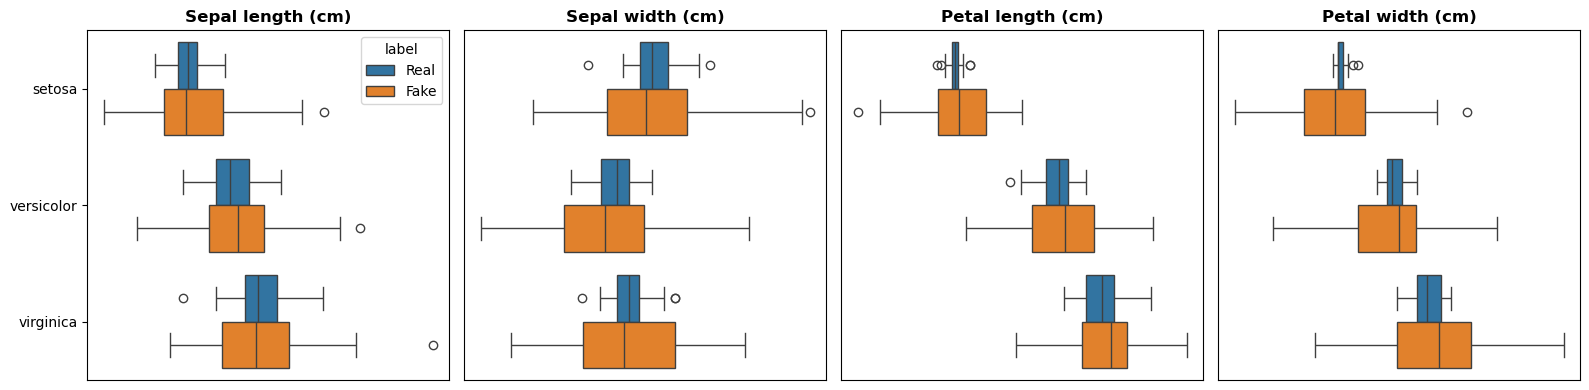

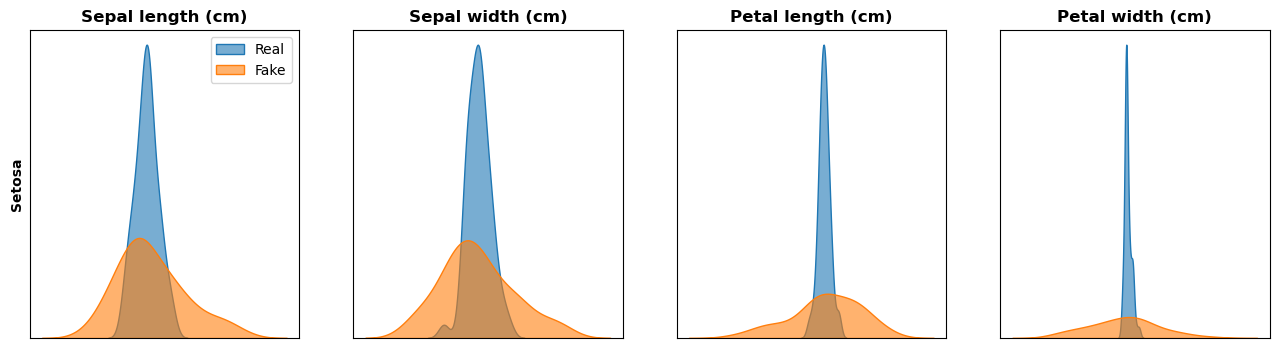

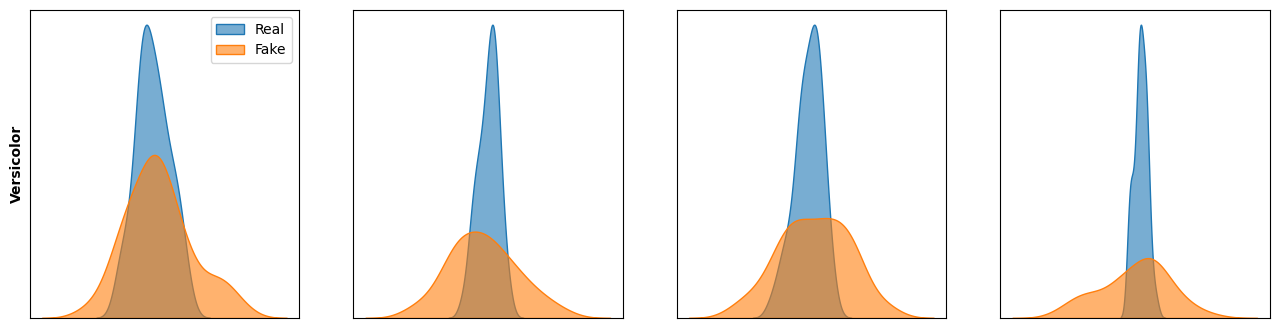

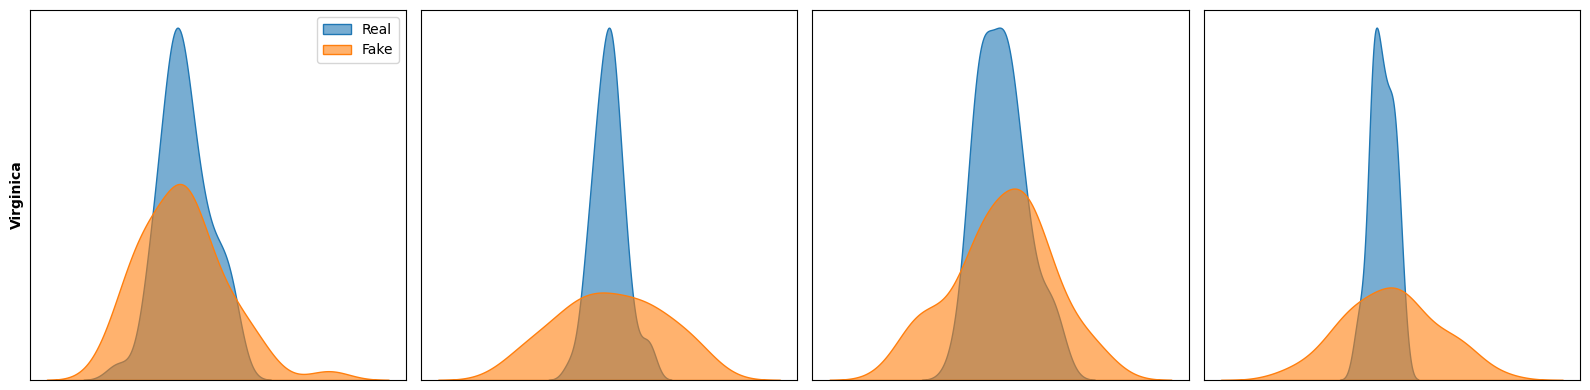

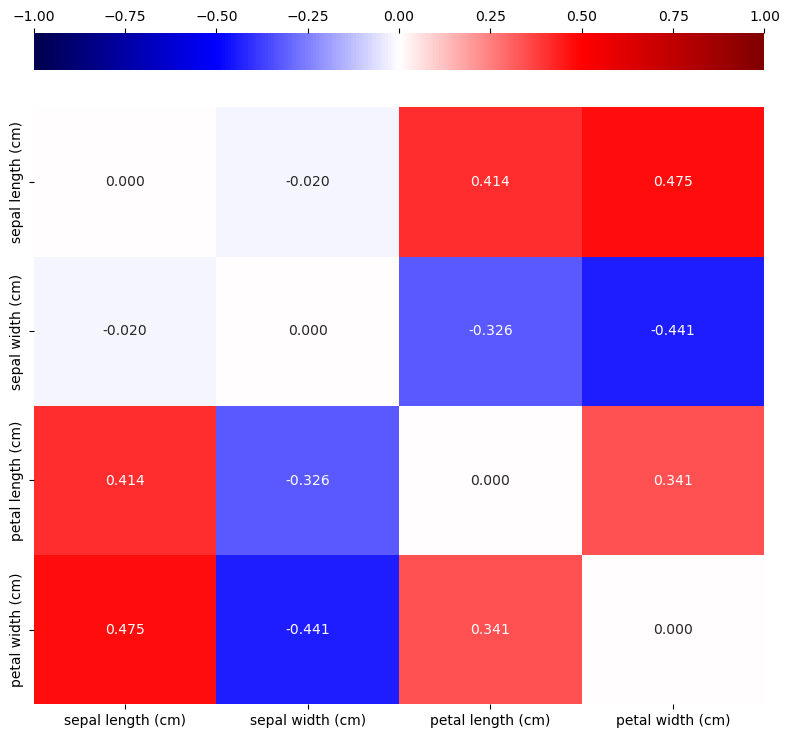

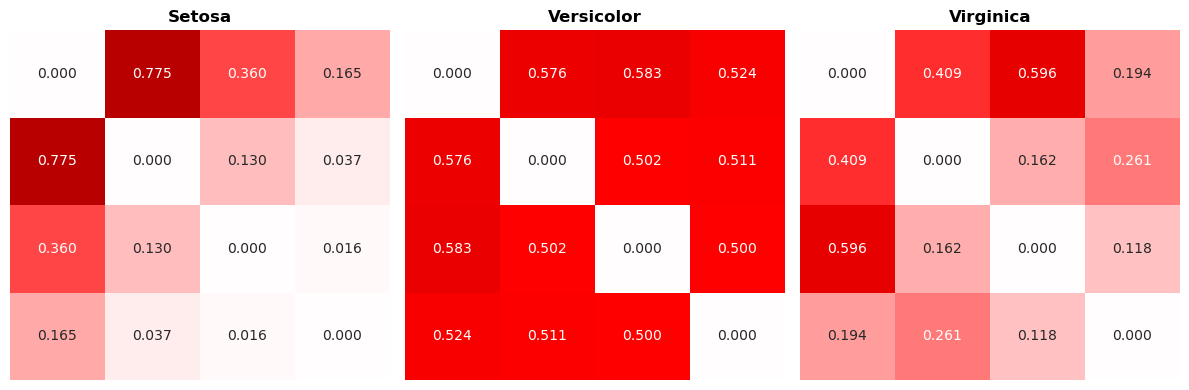

In [9]:
utils.plot_data(real_iris, 'target', df)

Throughout the work, the goal will be to minimize the differences, numerical and graphical, between the actual and synthetic data. Two different architectures will be used to achieve this goal: the Variational Auto Encoder **(VAE)** and the Generative Adversarial Network **(GAN)**, and the one that will show the best performance for the same task complexity and resources will be selected.

## GAN vs VAE

Both valid, the two approaches show different challenges and advantages:

1. **Variational Auto Encoder**:

Pros:
- Easy to train
- We can look inside the neaural network "Black Box"

Cons:

- Less coverage of variability
- Assumption of data normality

2. **Generative Adversarial Network**:

Pros:
- More realistic generated data
- Flexibility with respect to actual data distributions

Cons:
- Hard to train (model collapse, lot of resources, lot of data)
- Lower interpretability

The performance of the two architectures will be analyzed using them in as simple a version as possible. The next step will then be to prepare the data for modeling.

In [10]:
std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

ohe = OneHotEncoder(sparse_output = False)
y_ohe = ohe.fit_transform(y.reshape(-1,1))

Preparing Torch Dataset and Dataloader

In [11]:
class IrisDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
real_vae_dataset = IrisDataset(X_scld, y_ohe)
real_vae_dataloader = DataLoader(real_vae_dataset, batch_size = 32, shuffle = True)

real_gan_dataset = IrisDataset(X_scld, y)
real_gan_dataloader = DataLoader(real_gan_dataset, batch_size = 32, shuffle = True)

for dataloader in [real_vae_dataloader, real_gan_dataloader]:
    for batch in dataloader:
        print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
        break

Data shape: torch.Size([32, 4]), labels shape: torch.Size([32, 3])
Data shape: torch.Size([32, 4]), labels shape: torch.Size([32])


Let's build baseline models, starting with the Conditional VAE

In [12]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Tanh()
        )
        
    def encode(self, x, c):
        x_cond = torch.cat([x, c], dim=1)
        h = self.encoder(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar
    
set_seed()
vae = ConditionalVAE(input_dim = 4, latent_dim = 4, condition_dim = 3)

for batch in real_vae_dataloader:
    vae_batch = batch
    break
    
vae_out = vae(vae_batch[0], vae_batch[1])
for out in vae_out:
    print(f'Shape: {out.shape}')

Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])


Now let's build the GANs net.

In [13]:
class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

set_seed()    
gen = Generator(input_dim = 4, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

for batch in real_gan_dataloader:
    gan_batch = batch
    break
    
print(f'Generator output shape: {gen(torch.randn(32, 4), gan_batch[1]).shape}')
print(f'Discriminator output shape: {disc(gan_batch[0], gan_batch[1]).shape}')

Generator output shape: torch.Size([32, 4])
Discriminator output shape: torch.Size([32, 1])


Let's check models' size in parameters.

In [14]:
print(f'VAE has {sum(p.numel() for p in vae.parameters())} parameters')
print(f'Gen has {sum(p.numel() for p in gen.parameters())} parameters')
print(f'Disc has {sum(p.numel() for p in disc.parameters())} parameters')

VAE has 1724 parameters
Gen has 861 parameters
Disc has 714 parameters


We can now train the simpliest Conditional VAE.

In [15]:
vae_opt = torch.optim.Adam(vae.parameters(), lr = 1e-3)

def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div /= original.size(0)

    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

set_seed()

z = torch.randn(150, 4)
z[:10]

tensor([[-1.1258, -1.1524, -0.2506, -0.4339],
        [ 0.8487,  0.6920, -0.3160, -2.1152],
        [ 0.3223, -1.2633,  0.3500,  0.3081],
        [ 0.1198,  1.2377,  1.1168, -0.2473],
        [-1.3527, -1.6959,  0.5667,  0.7935],
        [ 0.5988, -1.5551, -0.3414,  1.8530],
        [ 0.7502, -0.5855, -0.1734,  0.1835],
        [ 1.3894,  1.5863,  0.9463, -0.8437],
        [-0.6136,  0.0316, -0.4927,  0.2484],
        [ 0.4397,  0.1124,  0.6408,  0.4412]])

In [16]:
for epoch in tqdm(range(1, 501), desc = 'Training VAE'):
    
    vae.train()
    epoch_loss = 0
    
    for data, label in real_vae_dataloader:
        
        reconstructed, mu, logvar = vae(data, label)
        loss, recon_loss, kl_div = vae_loss(reconstructed, data, mu, logvar)
        
        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()
        
        epoch_loss += loss.item()
        
    epoch_total_loss = epoch_loss/len(real_vae_dataloader)
    
    if epoch % 50 == 0 or epoch == 50:
        
        print(f'\nEpoch {epoch}/500 | Loss: {epoch_total_loss:.4f}')
        with torch.no_grad():
            vae.eval()
            vae_z = vae(z, real_vae_dataloader.dataset.label)[0]
            utils.compare_results(real_vae_dataloader.dataset.data, vae_z)

Training VAE:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 50/500 | Loss: 0.3227
MEAN: [-0.017  0.008 -0.08  -0.051]
STD:  [0.283 0.434 0.225 0.253]
MIN:  [-0.897 -1.855 -0.581 -0.465]
MAX:  [1.615 2.23  0.845 0.815]
SKEW: [ 0.647 -0.348  0.128  0.281]
KURT: [0.931 1.651 0.12  0.177]

Epoch 100/500 | Loss: 0.2992
MEAN: [-0.002  0.003 -0.072 -0.032]
STD:  [0.233 0.374 0.194 0.207]
MIN:  [-0.886 -1.741 -0.572 -0.453]
MAX:  [1.535 2.182 0.8   0.733]
SKEW: [ 0.473 -0.185  0.048  0.104]
KURT: [0.938 1.675 0.115 0.176]

Epoch 150/500 | Loss: 0.2957
MEAN: [-0.013 -0.002 -0.088 -0.049]
STD:  [0.224 0.366 0.185 0.194]
MIN:  [-0.88  -1.726 -0.569 -0.45 ]
MAX:  [1.539 2.196 0.8   0.727]
SKEW: [ 0.495 -0.12   0.082  0.131]
KURT: [0.928 1.68  0.109 0.17 ]

Epoch 200/500 | Loss: 0.2884
MEAN: [-0.023 -0.005 -0.1   -0.062]
STD:  [0.219 0.363 0.179 0.188]
MIN:  [-0.878 -1.708 -0.569 -0.448]
MAX:  [1.539 2.173 0.796 0.723]
SKEW: [ 0.521 -0.087  0.11   0.157]
KURT: [0.927 1.677 0.107 0.167]

Epoch 250/500 | Loss: 0.2928
MEAN: [-0.012  0.013 -0.091 -0.05 ]

In [17]:
vae_df = pd.DataFrame(std_scl.inverse_transform(vae_z.detach().numpy()))
vae_df['target'] = y
vae_df['target'] = vae_df['target'].map({i: species[i] for i in range(len(species))})
vae_df.columns = real_iris.columns

In [18]:
utils.describe_data(real_iris, 'target', vae_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.024      5.942   
     sepal width (cm)   3.428      2.770     2.974     3.428      2.770   
     petal length (cm)  1.462      4.260     5.552     1.999      4.277   
     petal width (cm)   0.246      1.326     2.026     0.440      1.338   
STD  sepal length (cm)  0.352      0.516     0.636     0.002      0.016   
     sepal width (cm)   0.379      0.314     0.322     0.010      0.010   
     petal length (cm)  0.174      0.470     0.552     0.000      0.062   
     petal width (cm)   0.105      0.198     0.275     0.000      0.030   
MIN  sepal length (cm)  4.300      4.900     4.900     5.021      5.899   
     sepal width (cm)   2.300      2.000     2.200     3.403      2.751   
     petal length (cm)  1.000      3.000     4.500     1.999      4.178   
     petal width (cm)   0.100      1.000     1.400     0.440      1.290   
MAX  sepal length (cm)  5.800      7.000     7.900     5.027      5.981   
     sepal width (cm)   4.400      3.400     3.800     3.444      2.800   
     petal length (cm)  1.900      5.100     6.900     2.000      4.444   
     petal width (cm)   0.600      1.800     2.500     0.440      1.425   
SKEW sepal length (cm)  0.116      0.102     0.114     0.040     -0.189   
     sepal width (cm)   0.040     -0.352     0.355    -0.619      0.352   
     petal length (cm)  0.103     -0.588     0.533     0.269      0.926   
     petal width (cm)   1.216     -0.030    -0.126     0.190      0.985   
KURT sepal length (cm) -0.346     -0.599    -0.088    -1.053      0.820   
     sepal width (cm)   0.744     -0.448     0.520    -0.433     -0.054   
     petal length (cm)  0.805     -0.074    -0.256    -1.099      0.427   
     petal width (cm)   1.434     -0.488    -0.661    -1.122      0.705   
IQR  sepal length (cm)  0.400      0.700     0.675     0.002      0.013   
     sepal width (cm)   0.475      0.475     0.375     0.013      0.015   
     petal length (cm)  0.175      0.600     0.775     0.000      0.072   
     petal width (cm)   0.100      0.300     0.500     0.000      0.031   

                                  
                       virginica  
MEAN sepal length (cm)     6.595  
     sepal width (cm)      2.982  
     petal length (cm)     5.501  
     petal width (cm)      1.954  
STD  sepal length (cm)     0.016  
     sepal width (cm)      0.020  
     petal length (cm)     0.007  
     petal width (cm)      0.003  
MIN  sepal length (cm)     6.552  
     sepal width (cm)      2.937  
     petal length (cm)     5.480  
     petal width (cm)      1.947  
MAX  sepal length (cm)     6.623  
     sepal width (cm)      3.018  
     petal length (cm)     5.511  
     petal width (cm)      1.958  
SKEW sepal length (cm)    -0.502  
     sepal width (cm)     -0.200  
     petal length (cm)    -0.841  
     petal width (cm)     -1.252  
KURT sepal length (cm)    -0.063  
     sepal width (cm)     -0.813  
     petal length (cm)     0.288  
     petal width (cm)      1.289  
IQR  sepal length (cm)     0.020  
     sepal width (cm)      0.029  
     petal length (cm)     0.008  
     petal width (cm)      0.003

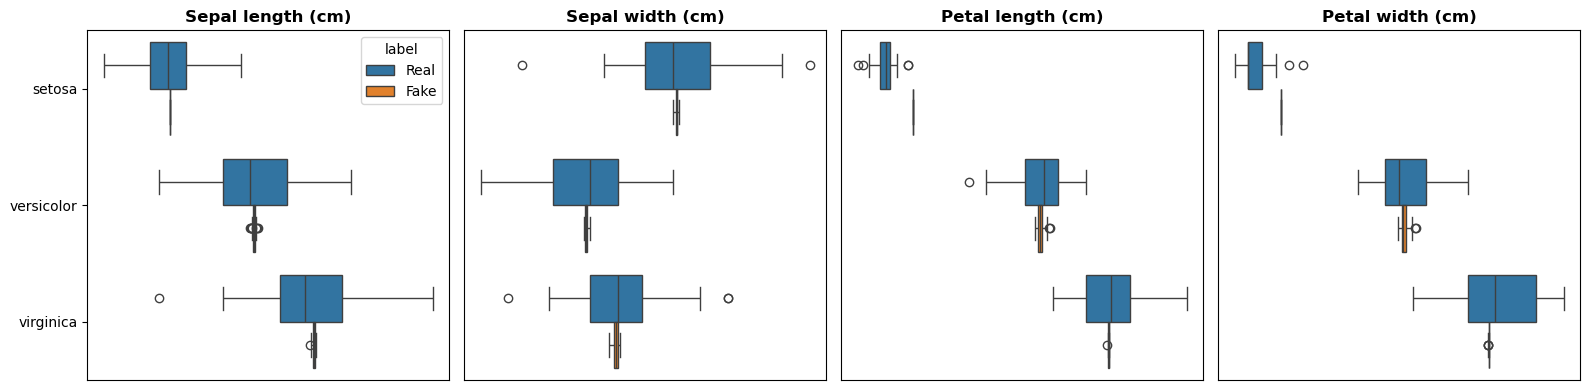

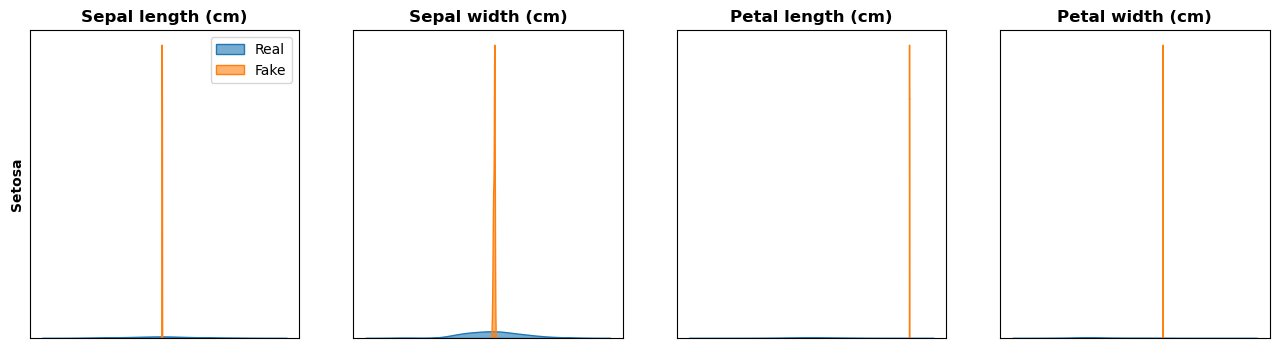

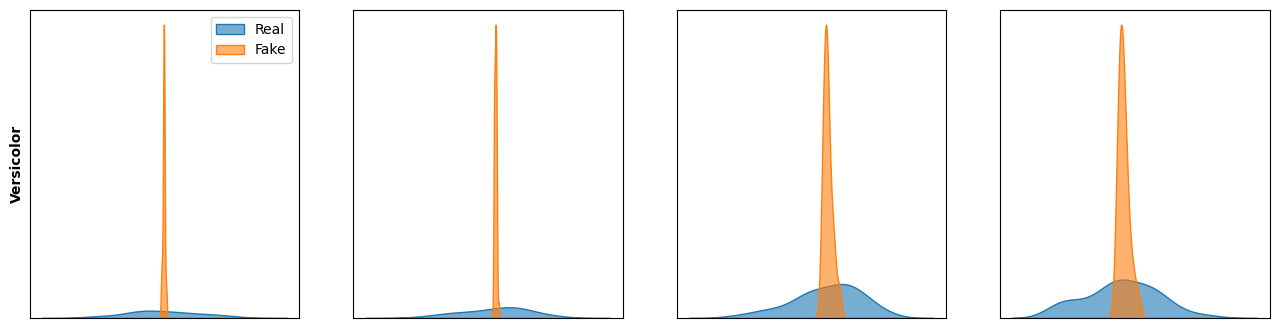

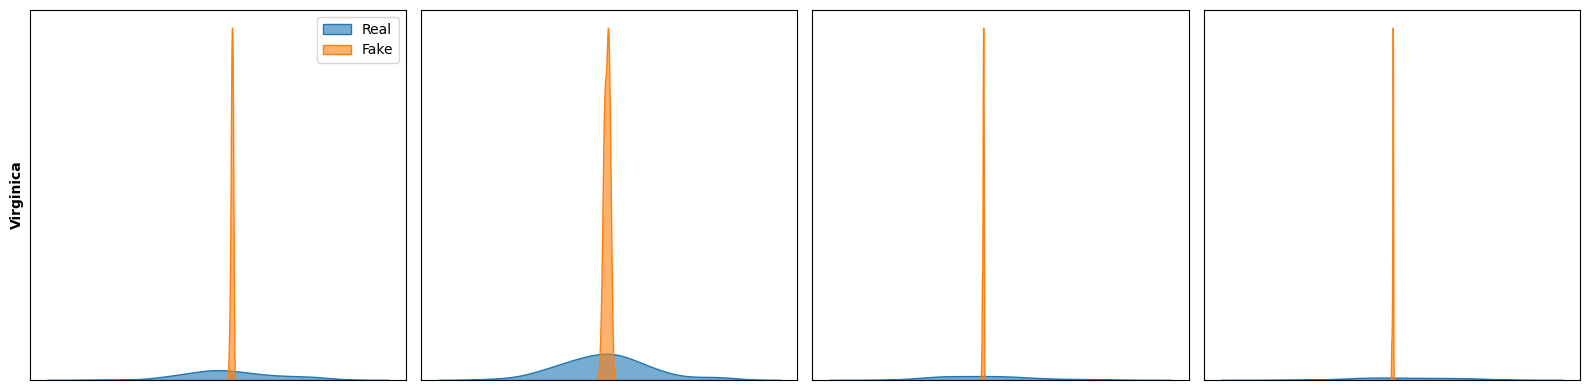

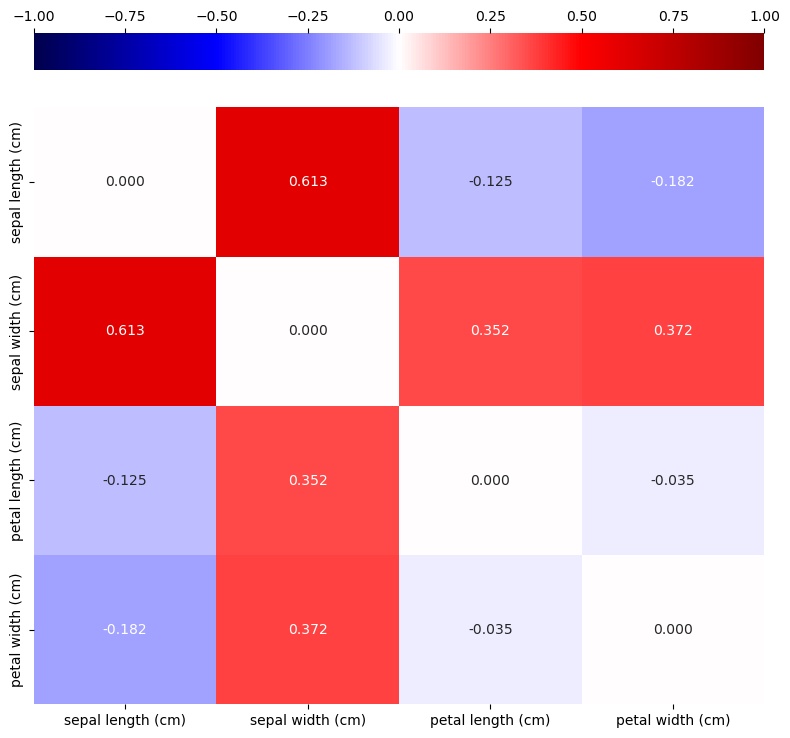

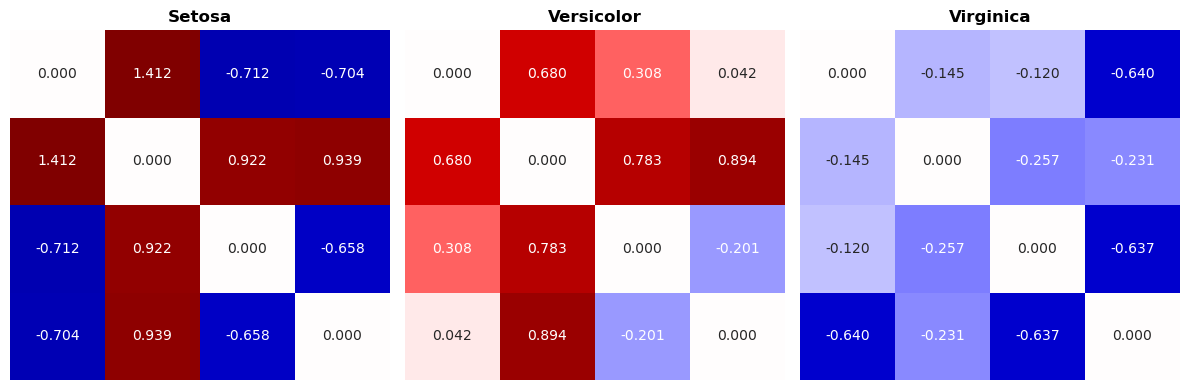

In [19]:
utils.plot_data(real_iris, 'target', vae_df)

Let's train the Conditional GAN.

In [20]:
g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [21]:
for epoch in tqdm(range(501), desc = 'Training Conditional GAN'):
    
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    
    disc.train()
    gen.train()
    
    for data, labels in real_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
        
        train_z = torch.randn(real_data.shape[0], 4)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
        
        d_opt.step()
        
        gen.zero_grad()
        
        gen_labels = torch.ones(real_data.shape[0], 1)
        
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 50 == 0 or epoch == 500:
        
        print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6895 | GLoss 0.7297
MEAN: [ 0.034  0.055 -0.102  0.011]
STD:  [0.963 0.96  0.964 0.94 ]
MIN:  [-1.707 -2.235 -1.571 -1.246]
MAX:  [2.438 3.037 1.556 1.559]
SKEW: [ 0.558  0.534 -0.497 -0.145]
KURT: [-1.136 -0.411 -2.345 -1.258]

Epoch 50/500 | DLoss: 0.2157 | GLoss 1.7507
MEAN: [ 4.109  1.191 -5.977  1.654]
STD:  [-0.055  0.584 -0.389  0.564]
MIN:  [ 5.757  0.225 -4.714  1.765]
MAX:  [ 4.354  3.51  -8.918  2.501]
SKEW: [ 0.755  1.178 -0.989  0.797]
KURT: [-1.331 -0.588 -2.307 -2.371]

Epoch 100/500 | DLoss: 0.2452 | GLoss 2.9670
MEAN: [-1.317  1.005 -1.867 -0.504]
STD:  [0.372 0.683 0.442 0.555]
MIN:  [-1.868 -0.47  -2.372 -0.832]
MAX:  [-0.687  3.513 -1.449 -0.08 ]
SKEW: [-0.052  0.785 -0.592 -0.194]
KURT: [-0.476  0.353 -0.799 -1.494]

Epoch 150/500 | DLoss: 0.8743 | GLoss 0.8036
MEAN: [-0.092 -0.285 -0.287  0.19 ]
STD:  [ 0.288  0.089 -0.256 -0.168]
MIN:  [-0.924 -1.617 -0.008  0.428]
MAX:  [ 1.301  1.266 -0.109  0.346]
SKEW: [ 0.45  -0.281  0.188  0.191]
KUR

In [22]:
gan_df = pd.DataFrame(std_scl.inverse_transform(gen_z.detach().numpy()))
gan_df['target'] = y
gan_df['target'] = gan_df['target'].map({i: species[i] for i in range(len(species))})
gan_df.columns = real_iris.columns

In [23]:
utils.describe_data(real_iris, 'target', gan_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.600      6.178   
     sepal width (cm)   3.428      2.770     2.974     3.483      3.064   
     petal length (cm)  1.462      4.260     5.552     1.874      4.212   
     petal width (cm)   0.246      1.326     2.026     0.119      1.312   
STD  sepal length (cm)  0.352      0.516     0.636     0.015      0.118   
     sepal width (cm)   0.379      0.314     0.322     0.069      0.088   
     petal length (cm)  0.174      0.470     0.552     0.102      0.228   
     petal width (cm)   0.105      0.198     0.275     0.062      0.082   
MIN  sepal length (cm)  4.300      4.900     4.900     5.561      6.010   
     sepal width (cm)   2.300      2.000     2.200     3.366      2.972   
     petal length (cm)  1.000      3.000     4.500     1.650      3.840   
     petal width (cm)   0.100      1.000     1.400    -0.065      1.205   
MAX  sepal length (cm)  5.800      7.000     7.900     5.648      6.455   
     sepal width (cm)   4.400      3.400     3.800     3.776      3.354   
     petal length (cm)  1.900      5.100     6.900     2.120      5.058   
     petal width (cm)   0.600      1.800     2.500     0.307      1.562   
SKEW sepal length (cm)  0.116      0.102     0.114     0.138      0.796   
     sepal width (cm)   0.040     -0.352     0.355     1.347      1.612   
     petal length (cm)  0.103     -0.588     0.533     0.213      1.604   
     petal width (cm)   1.216     -0.030    -0.126     0.021      1.007   
KURT sepal length (cm) -0.346     -0.599    -0.088     1.525     -0.432   
     sepal width (cm)   0.744     -0.448     0.520     4.869      1.884   
     petal length (cm)  0.805     -0.074    -0.256    -0.388      2.804   
     petal width (cm)   1.434     -0.488    -0.661     1.341      0.785   
IQR  sepal length (cm)  0.400      0.700     0.675     0.014      0.152   
     sepal width (cm)   0.475      0.475     0.375     0.077      0.083   
     petal length (cm)  0.175      0.600     0.775     0.137      0.176   
     petal width (cm)   0.100      0.300     0.500     0.077      0.116   

                                  
                       virginica  
MEAN sepal length (cm)     6.203  
     sepal width (cm)      3.229  
     petal length (cm)     5.955  
     petal width (cm)      2.399  
STD  sepal length (cm)     0.120  
     sepal width (cm)      0.094  
     petal length (cm)     0.263  
     petal width (cm)      0.180  
MIN  sepal length (cm)     5.786  
     sepal width (cm)      3.114  
     petal length (cm)     5.629  
     petal width (cm)      2.196  
MAX  sepal length (cm)     6.692  
     sepal width (cm)      3.521  
     petal length (cm)     7.138  
     petal width (cm)      3.179  
SKEW sepal length (cm)     0.460  
     sepal width (cm)      0.808  
     petal length (cm)     2.026  
     petal width (cm)      1.802  
KURT sepal length (cm)     6.563  
     sepal width (cm)      0.180  
     petal length (cm)     6.295  
     petal width (cm)      4.977  
IQR  sepal length (cm)     0.069  
     sepal width (cm)      0.138  
     petal length (cm)     0.300  
     petal width (cm)      0.206

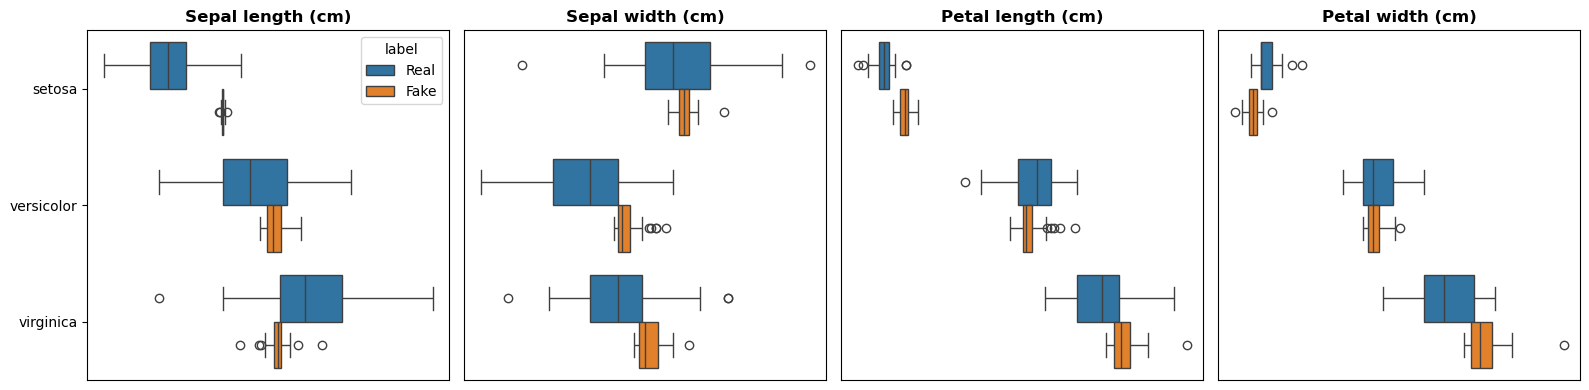

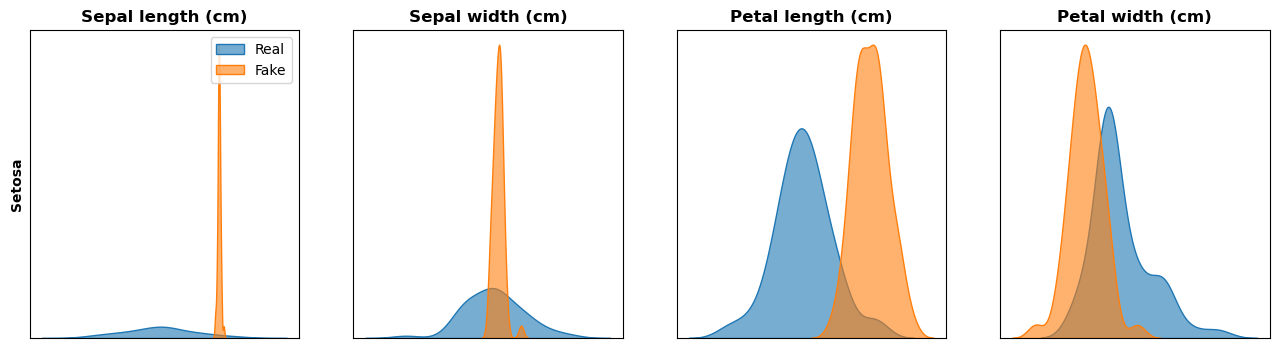

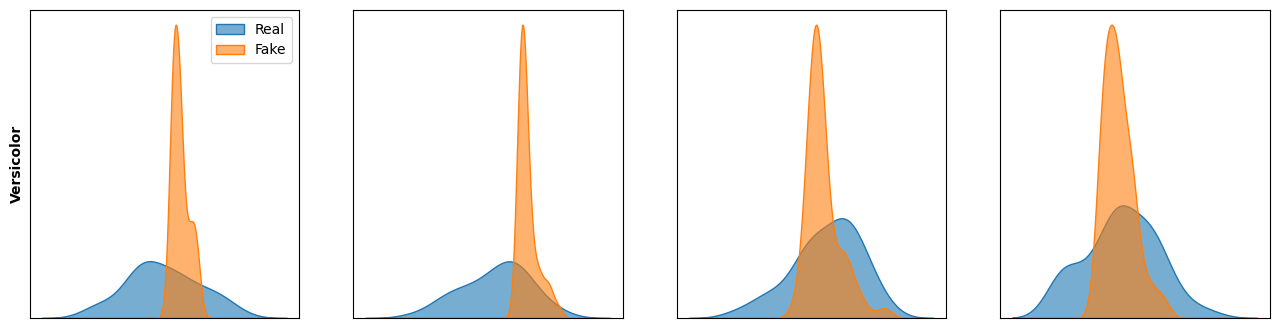

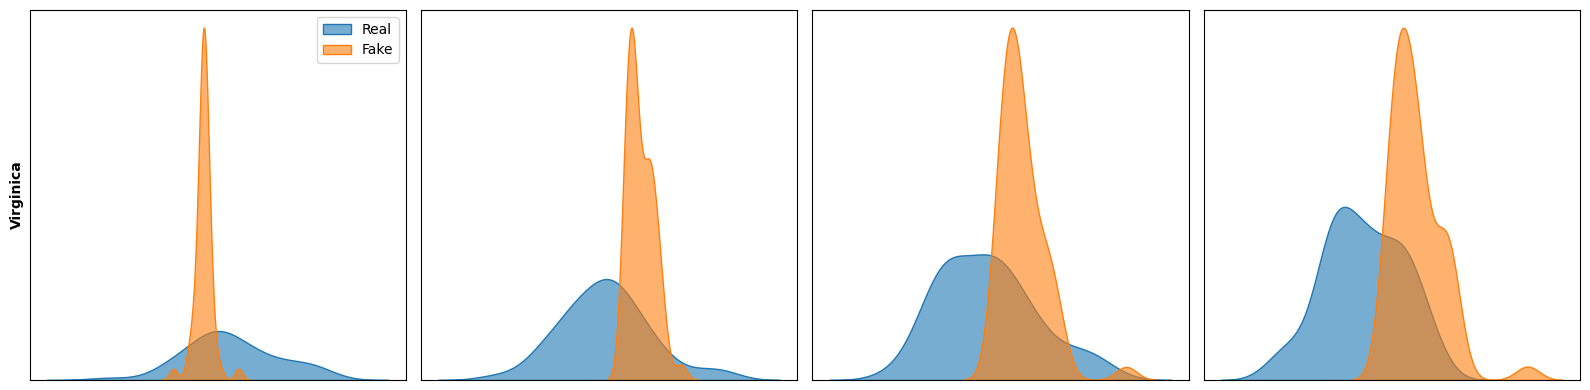

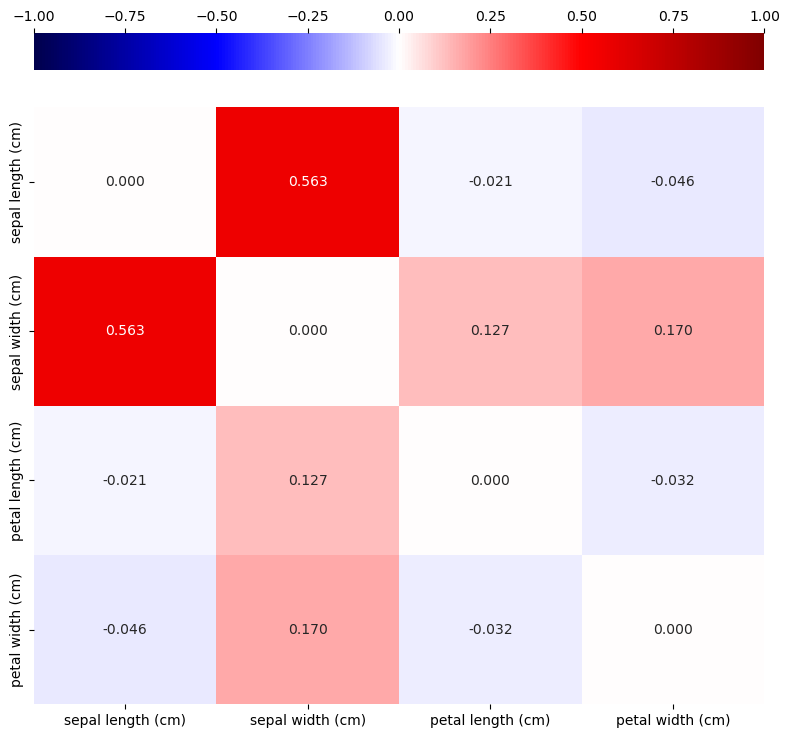

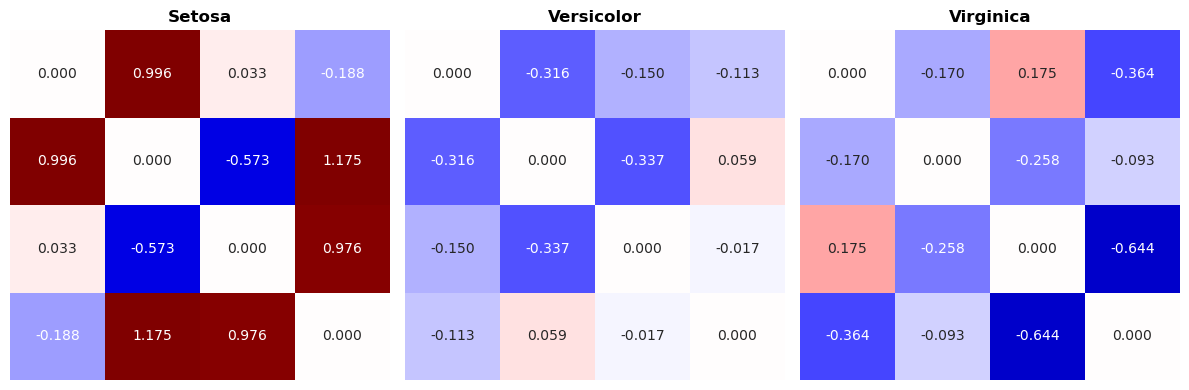

In [24]:
utils.plot_data(real_iris, 'target', gan_df)

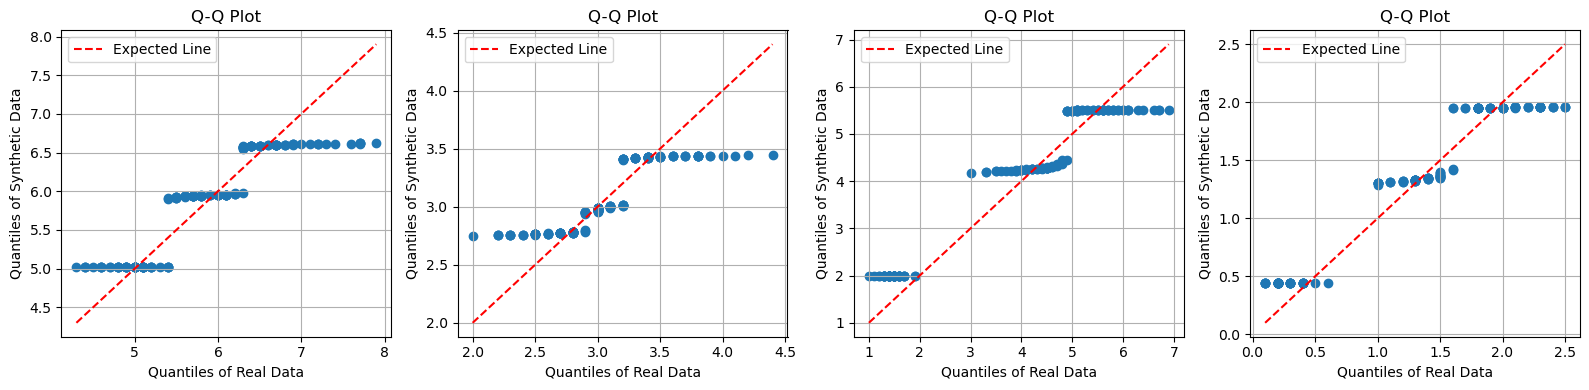

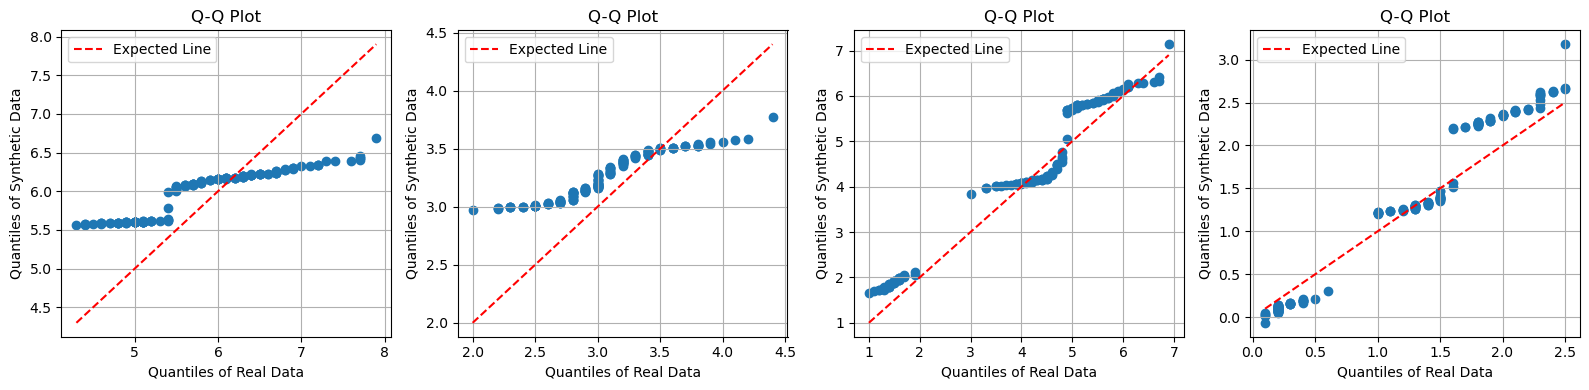

In [25]:
utils.plot_quantiles(real_iris, vae_df)
utils.plot_quantiles(real_iris, gan_df)

In [26]:
print((real_iris.select_dtypes('number').corr() - vae_df.select_dtypes('number').corr()).sum().sum())
print((real_iris.select_dtypes('number').corr() - gan_df.select_dtypes('number').corr()).sum().sum())

1.9909988839882367
1.5207409003029548


The performance of the models is clear: using Q-Q plots we see that the data generated with the simpler GAN show better overlap with the actual data. We will follow this path.

## Conditional Generative Adversarial Network

In this section, we focus on refining the GAN architecture to maximize its performance in generating synthetic data that closely resembles the real dataset. Our aim is to improve the overlap between the distributions of generated and real data while maintaining computational efficiency. The resulting model will form the basis for subsequent evaluations and applications.

The strating point is a model with 861 parameters. We'll build other 2 bigger versions to prove out which is the best.

In [27]:
# Smallest GAN

class Generator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Medium GAN

class Generator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Big GAN

class Generator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
set_seed()    
small_gan_gen = Generator1(input_dim = 4, num_classes = 3)
small_gan_disc = Discriminator1(input_dim = 4, num_classes = 3)

med_gan_gen = Generator2(input_dim = 4, num_classes = 3)
med_gan_disc = Discriminator2(input_dim = 4, num_classes = 3)

big_gan_gen = Generator3(input_dim = 4, num_classes = 3)
big_gan_disc = Discriminator3(input_dim = 4, num_classes = 3)

small_gan = {'Generator':small_gan_gen, 'Discriminator':small_gan_disc}

med_gan = {'Generator':med_gan_gen, 'Discriminator':med_gan_disc}

big_gan = {'Generator':big_gan_gen, 'Discriminator':big_gan_disc}

In [28]:
for size in [small_gan, med_gan, big_gan]:
    for model in size:
        print(f'{model} parameters: {sum(p.numel() for p in size[model].parameters())/1000}k')

Generator parameters: 0.861k
Discriminator parameters: 0.714k
Generator parameters: 3.197k
Discriminator parameters: 2.858k
Generator parameters: 11.965k
Discriminator parameters: 11.242k


The 3 models have a very different number of parameters. Next step is to set the optimized ones and start training.

In [29]:
small_gan['Generator optimizer'] = torch.optim.Adam(small_gan_gen.parameters(), lr = 1e-3)
small_gan['Discriminator optimizer'] = torch.optim.Adam(small_gan_disc.parameters(), lr = 1e-3)

med_gan['Generator optimizer'] = torch.optim.Adam(med_gan_gen.parameters(), lr = 1e-3)
med_gan['Discriminator optimizer'] = torch.optim.Adam(med_gan_disc.parameters(), lr = 1e-3)

big_gan['Generator optimizer'] = torch.optim.Adam(big_gan_gen.parameters(), lr = 1e-3)
big_gan['Discriminator optimizer'] = torch.optim.Adam(big_gan_disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [30]:
for idx, size in enumerate([small_gan, med_gan, big_gan]):
    
    for epoch in tqdm(range(501), desc = f'Training Conditional GAN {idx + 1}'):
        
        gen = size['Generator']
        disc = size['Discriminator']
        g_opt = size['Generator optimizer']
        d_opt = size['Discriminator optimizer']
        
        gen_epoch_loss = 0
        disc_epoch_loss = 0
    
        disc.train()
        gen.train()
        
        for data, labels in real_gan_dataloader:
            
            real_data = data
            real_labels = torch.ones(real_data.shape[0], 1)
        
            train_z = torch.randn(real_data.shape[0], 4)
            fake_data = gen(train_z, labels)
            fake_labels = torch.zeros(real_data.shape[0], 1)
        
            disc.zero_grad()
            
            real_loss = criterion(disc(real_data, labels), real_labels)
            fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
            d_loss = (real_loss + fake_loss) / 2
            disc_epoch_loss += d_loss.item()
            d_loss.backward()
        
            d_opt.step()
        
            gen.zero_grad()
        
            gen_labels = torch.ones(real_data.shape[0], 1)
        
            g_loss = criterion(disc(fake_data, labels), gen_labels)
            gen_epoch_loss += g_loss.item()
            g_loss.backward()
        
            g_opt.step()
            
        g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
        d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
        
        if epoch % 100 == 0 or epoch == 500:
        
            print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
            with torch.no_grad():
                gen.eval()
                gen_z = gen(z, real_gan_dataloader.dataset.label)
                utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN 1:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6895 | GLoss 0.7297
MEAN: [ 0.034  0.055 -0.102  0.011]
STD:  [0.963 0.96  0.964 0.94 ]
MIN:  [-1.707 -2.235 -1.571 -1.246]
MAX:  [2.438 3.037 1.556 1.559]
SKEW: [ 0.558  0.534 -0.497 -0.145]
KURT: [-1.136 -0.411 -2.345 -1.258]

Epoch 100/500 | DLoss: 0.2452 | GLoss 2.9670
MEAN: [-1.317  1.005 -1.867 -0.504]
STD:  [0.372 0.683 0.442 0.555]
MIN:  [-1.868 -0.47  -2.372 -0.832]
MAX:  [-0.687  3.513 -1.449 -0.08 ]
SKEW: [-0.052  0.785 -0.592 -0.194]
KURT: [-0.476  0.353 -0.799 -1.494]

Epoch 200/500 | DLoss: 0.7651 | GLoss 0.6986
MEAN: [-0.282  0.359  0.281  0.065]
STD:  [0.317 0.885 0.059 0.026]
MIN:  [-1.181 -1.773  0.238  0.039]
MAX:  [1.227 3.244 0.982 0.434]
SKEW: [0.517 0.643 0.336 0.254]
KURT: [0.909 0.954 0.087 0.159]

Epoch 300/500 | DLoss: 0.5725 | GLoss 0.8519
MEAN: [-0.056 -0.237 -0.07  -0.099]
STD:  [ 0.062 -0.067  0.103 -0.09 ]
MIN:  [-0.737 -0.717 -0.43  -0.291]
MAX:  [ 0.762  1.751  0.501 -0.29 ]
SKEW: [-0.284  0.933 -0.2   -0.778]
KURT: [0.84  1.478

Training Conditional GAN 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6892 | GLoss 0.7112
MEAN: [ 0.029 -0.212  0.158 -0.227]
STD:  [0.993 0.971 0.99  0.99 ]
MIN:  [-1.791 -2.592 -1.359 -1.618]
MAX:  [2.498 2.764 1.902 1.454]
SKEW: [ 0.998 -0.785  0.251  0.5  ]
KURT: [-3.209 -1.33  -3.545 -2.968]

Epoch 100/500 | DLoss: 0.4109 | GLoss 1.6877
MEAN: [-1.352  0.71  -0.161 -1.969]
STD:  [0.605 0.713 0.916 0.422]
MIN:  [-2.47  -1.073 -1.571 -2.343]
MAX:  [ 0.13   3.18   1.374 -1.667]
SKEW: [ 0.318  0.136 -0.459 -0.069]
KURT: [ 0.123  0.851 -0.905 -0.537]

Epoch 200/500 | DLoss: 0.3985 | GLoss 1.8685
MEAN: [-0.381  0.43  -0.379 -0.399]
STD:  [0.705 0.892 0.742 0.807]
MIN:  [-1.823 -1.8   -1.661 -1.583]
MAX:  [1.434 3.34  0.548 0.87 ]
SKEW: [ 0.309  0.247 -1.14  -0.223]
KURT: [ 0.684  1.551 -1.206 -0.086]

Epoch 300/500 | DLoss: 0.2865 | GLoss 2.3997
MEAN: [-0.243  0.171 -0.339 -0.406]
STD:  [0.689 0.932 0.889 0.463]
MIN:  [-1.559 -2.147 -1.784 -1.088]
MAX:  [1.464 3.023 1.208 0.125]
SKEW: [-0.409 -0.838 -0.76  -0.819]
KURT: [ 0.364 -0.6

Training Conditional GAN 3:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6904 | GLoss 0.6818
MEAN: [-0.157 -0.098  0.145 -0.128]
STD:  [0.993 0.984 0.998 0.992]
MIN:  [-1.997 -2.488 -1.412 -1.538]
MAX:  [2.304 2.96  1.906 1.564]
SKEW: [ 0.004  0.5   -1.2    0.378]
KURT: [-0.97   1.17  -3.939 -1.179]

Epoch 100/500 | DLoss: 0.4685 | GLoss 1.5726
MEAN: [-0.255  1.421 -0.58  -0.14 ]
STD:  [0.988 0.636 0.814 0.844]
MIN:  [-2.086  0.117 -1.872 -1.163]
MAX:  [2.195 3.882 0.859 1.275]
SKEW: [ 0.388  0.742 -0.514 -0.144]
KURT: [-0.19   0.182  0.081 -0.883]

Epoch 200/500 | DLoss: 0.6999 | GLoss 0.6929
MEAN: [-1.081  0.651  0.205 -0.524]
STD:  [-0.327  0.35  -0.02  -0.14 ]
MIN:  [-1.288 -0.247  0.584 -0.498]
MAX:  [-0.6    2.78   0.681 -0.467]
SKEW: [ 0.126  0.373 -0.23  -0.672]
KURT: [0.923 1.22  0.027 0.161]

Epoch 300/500 | DLoss: 0.7523 | GLoss 0.8646
MEAN: [-0.003 -0.333  0.04  -0.118]
STD:  [-0.412  0.006 -0.252 -0.329]
MIN:  [2.139 0.344 1.982 0.974]
MAX:  [-0.401  1.227 -0.588 -0.401]
SKEW: [0.127 1.09  0.061 0.445]
KURT: [ 0.26   0.5

Great! Now we can compare the results to choose the best architecture.

In [31]:
gen1_z = small_gan['Generator'](z, real_gan_dataloader.dataset.label)
gen2_z = med_gan['Generator'](z, real_gan_dataloader.dataset.label)
gen3_z = big_gan['Generator'](z, real_gan_dataloader.dataset.label)

In [32]:
gan1_df = pd.DataFrame(std_scl.inverse_transform(gen1_z.detach().numpy()))
gan1_df['target'] = y
gan1_df['target'] = gan1_df['target'].map({i: species[i] for i in range(len(species))})
gan1_df.columns = real_iris.columns

gan2_df = pd.DataFrame(std_scl.inverse_transform(gen2_z.detach().numpy()))
gan2_df['target'] = y
gan2_df['target'] = gan2_df['target'].map({i: species[i] for i in range(len(species))})
gan2_df.columns = real_iris.columns

gan3_df = pd.DataFrame(std_scl.inverse_transform(gen3_z.detach().numpy()))
gan3_df['target'] = y
gan3_df['target'] = gan3_df['target'].map({i: species[i] for i in range(len(species))})
gan3_df.columns = real_iris.columns

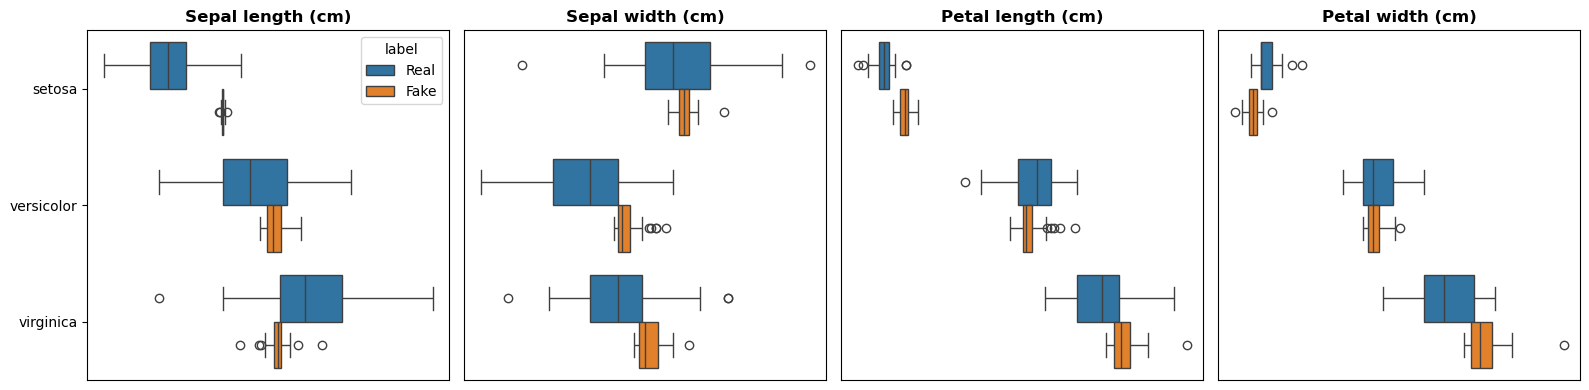

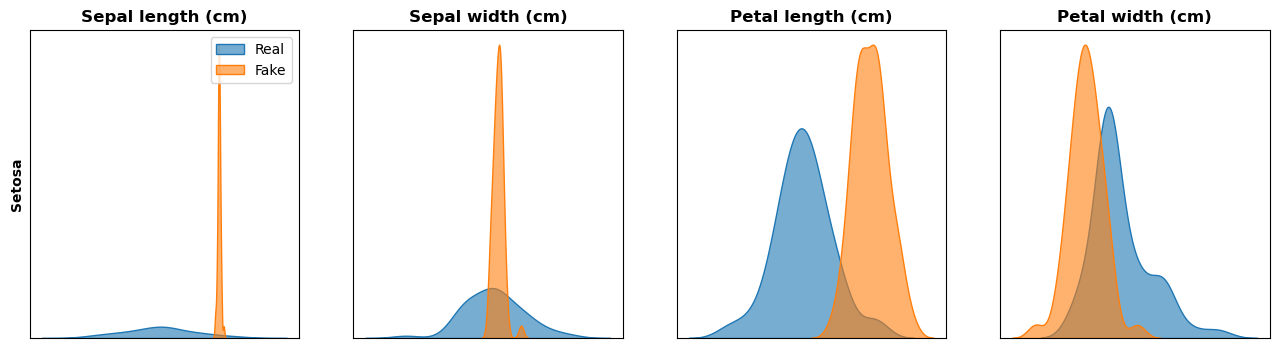

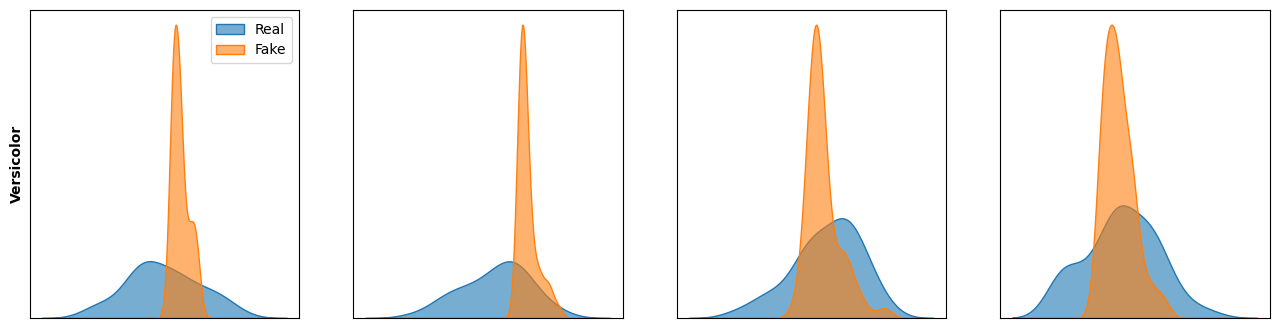

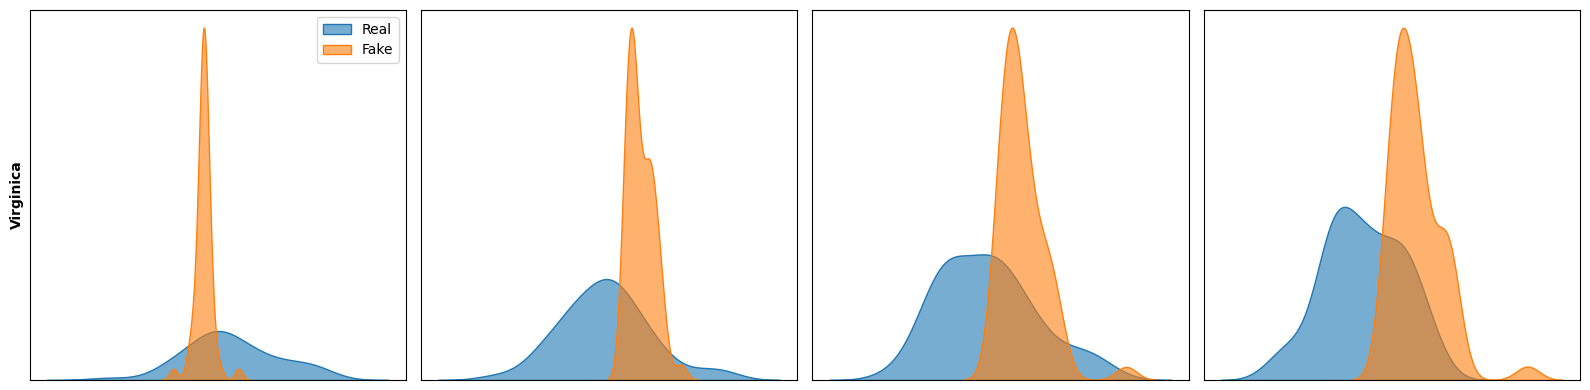

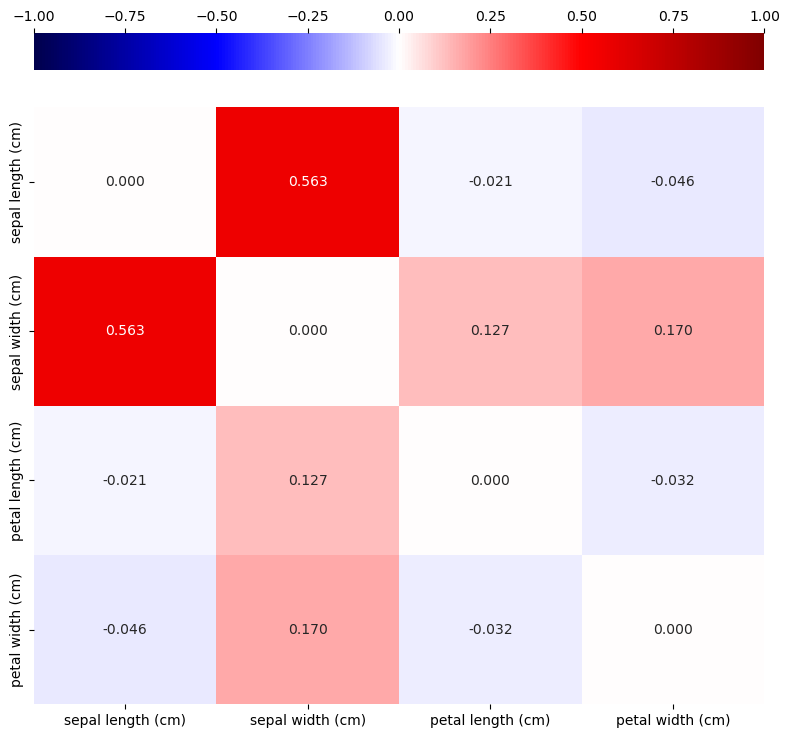

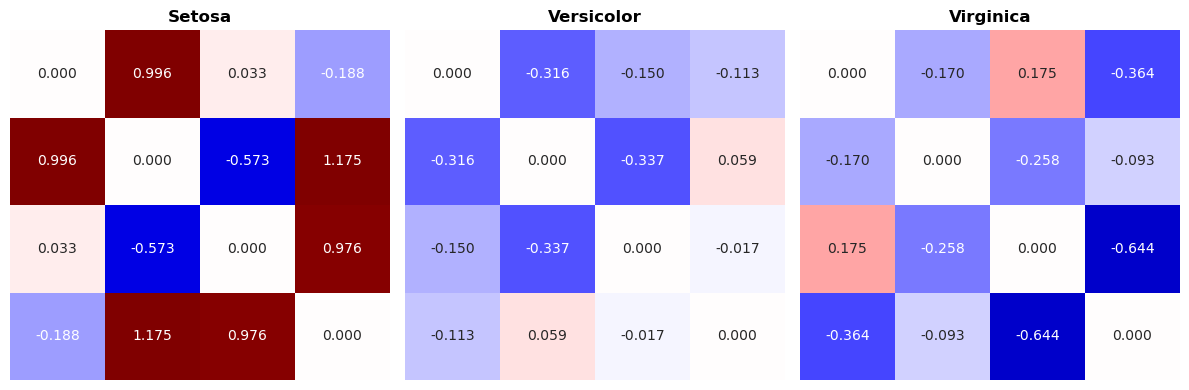

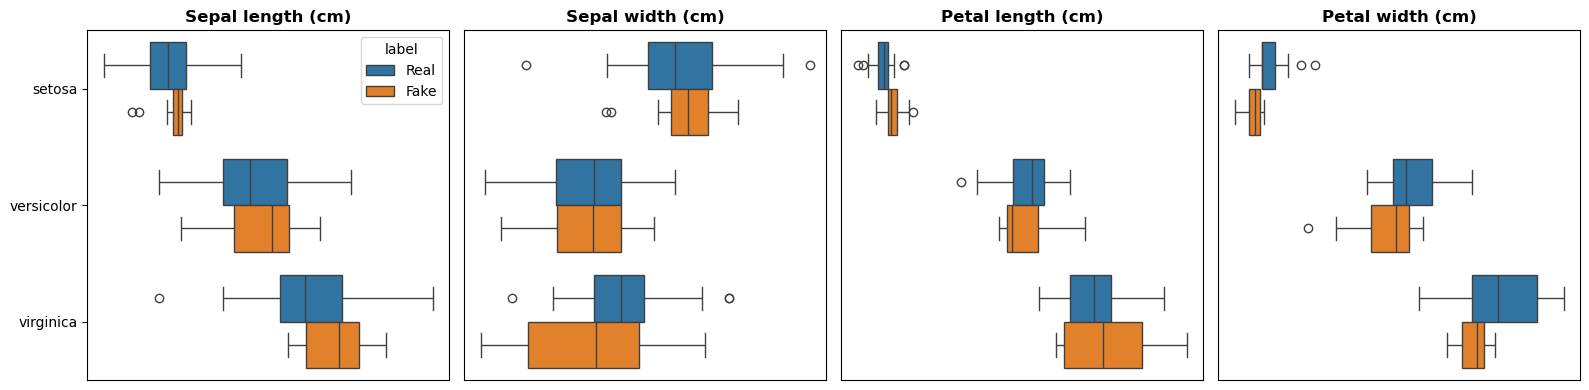

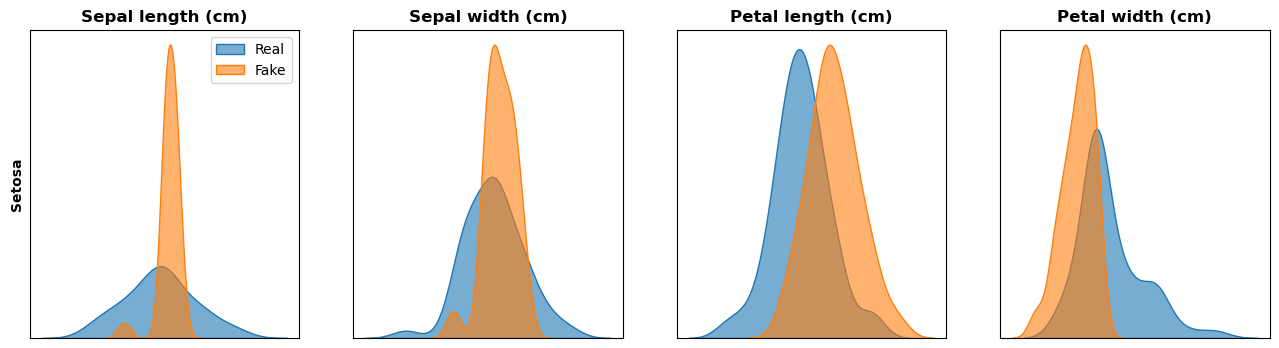

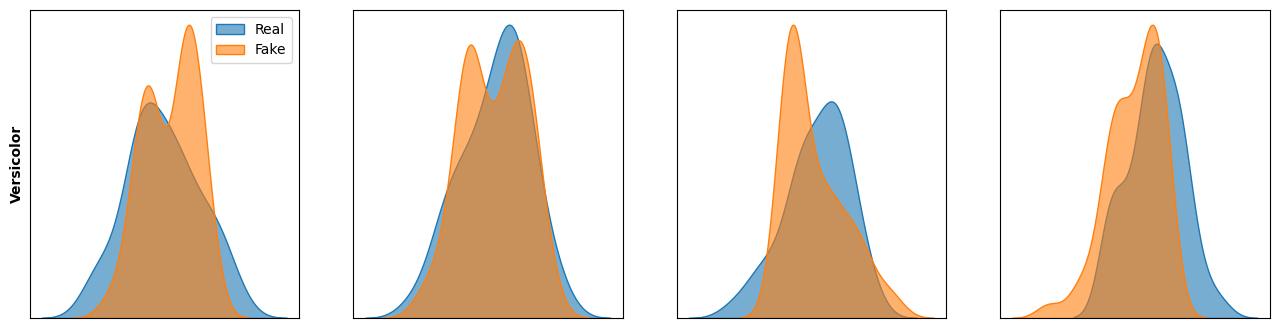

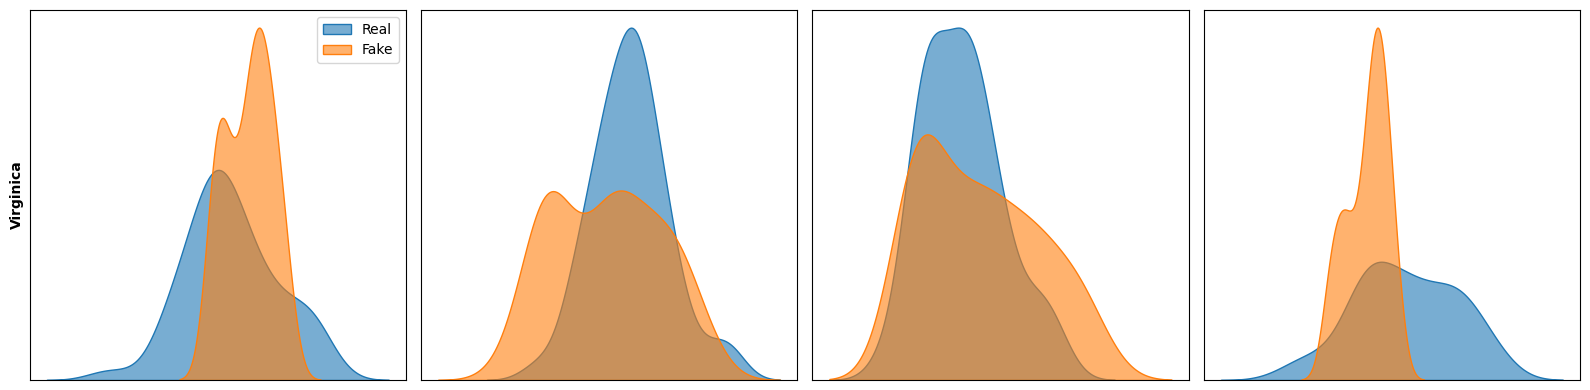

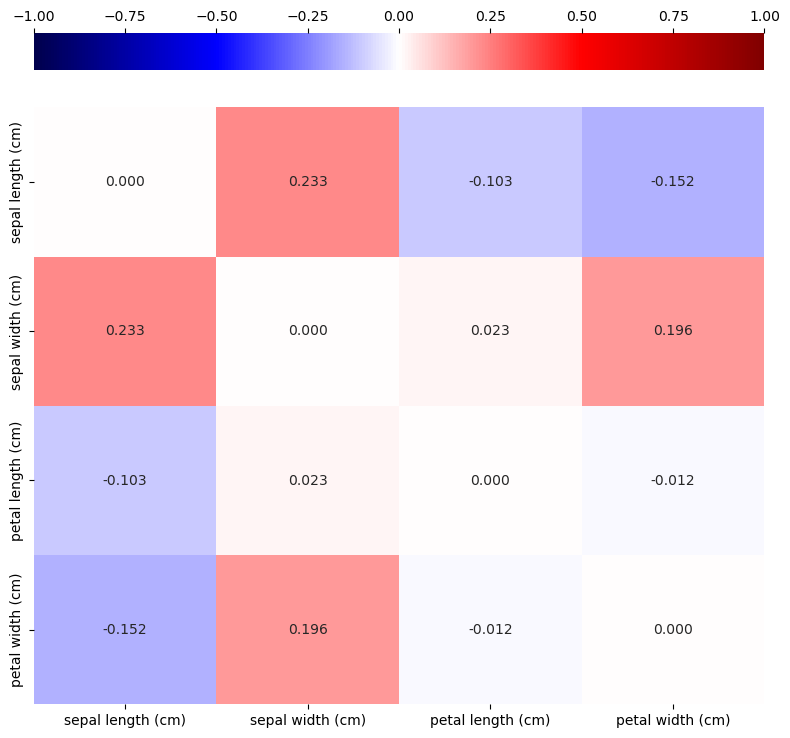

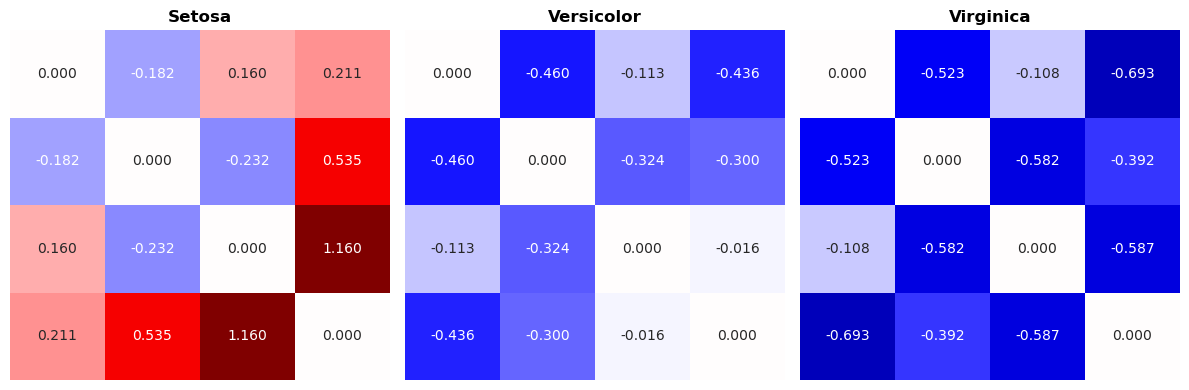

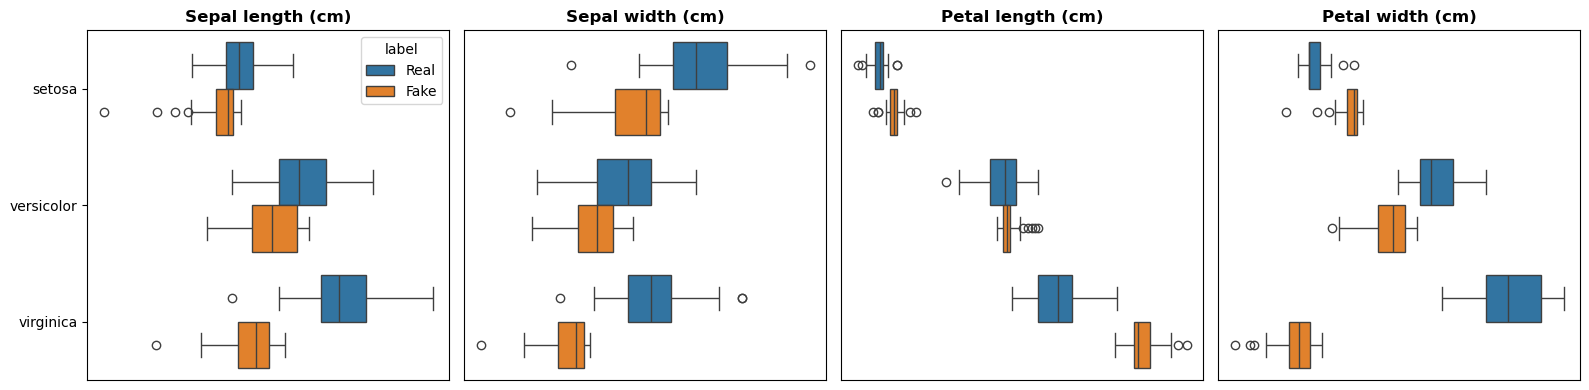

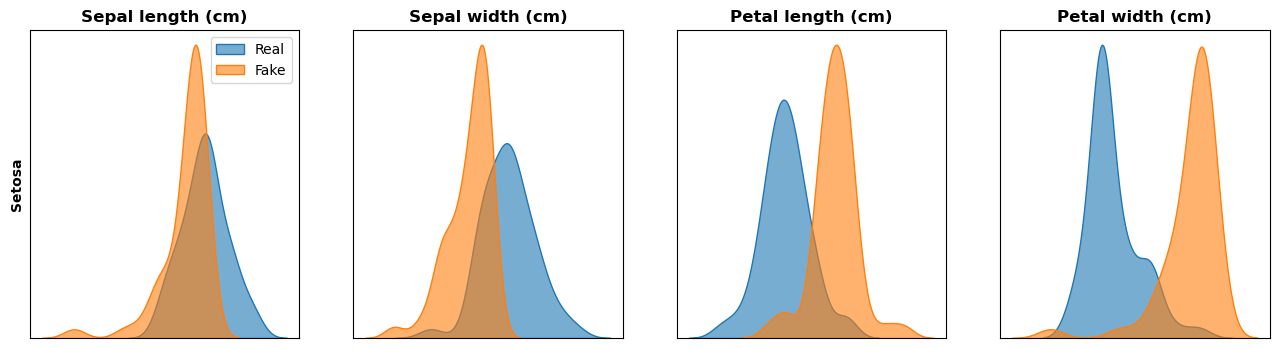

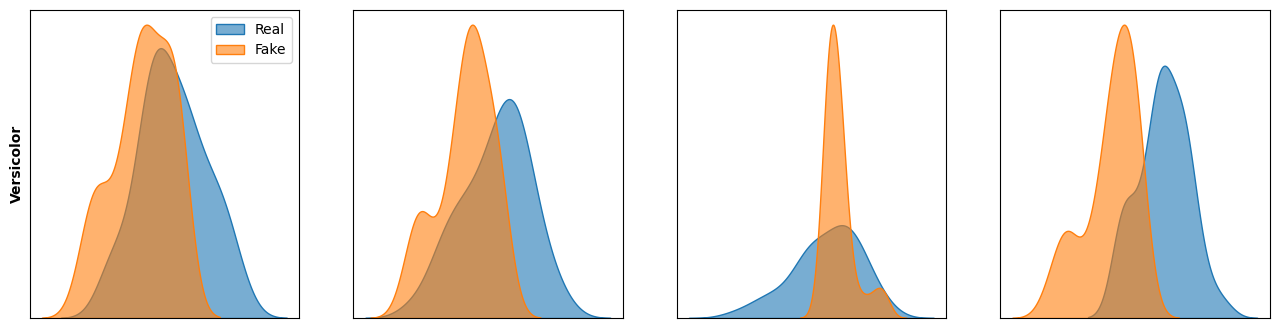

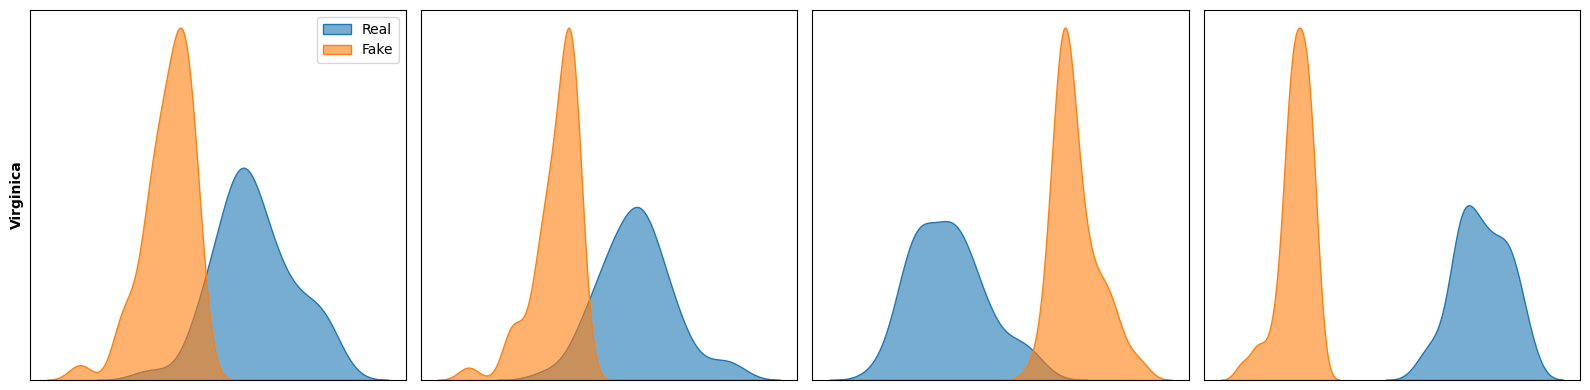

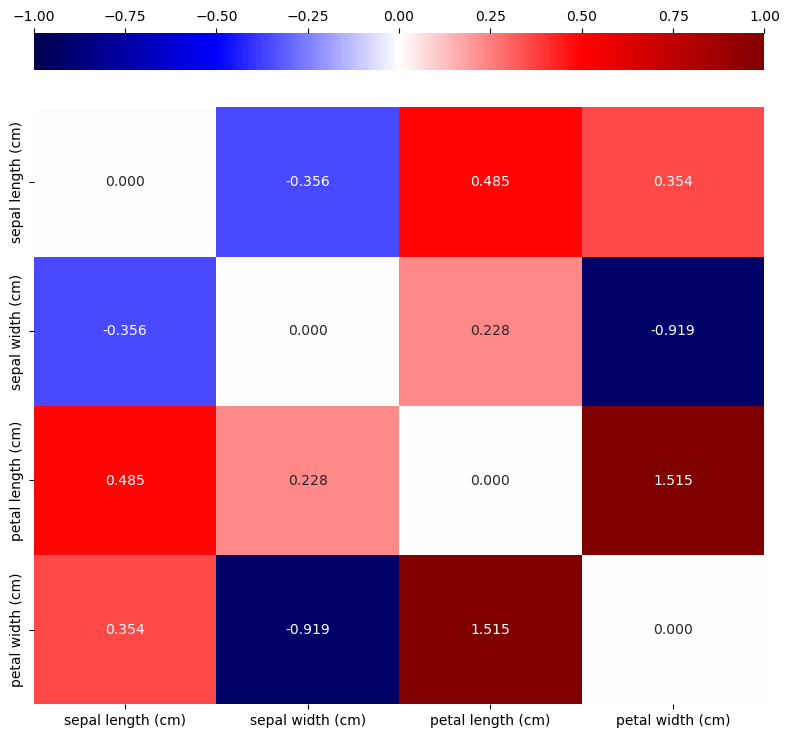

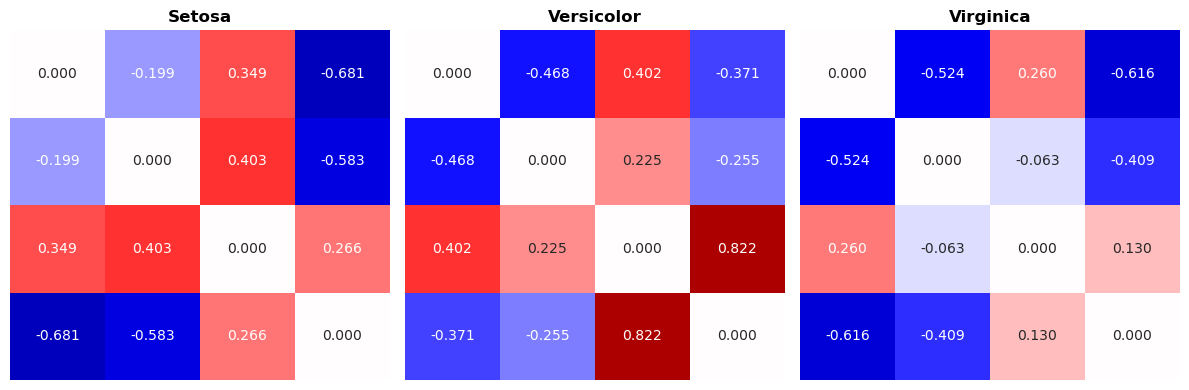

In [33]:
utils.plot_data(real_iris, 'target', gan1_df)
utils.plot_data(real_iris, 'target', gan2_df)
utils.plot_data(real_iris, 'target', gan3_df)

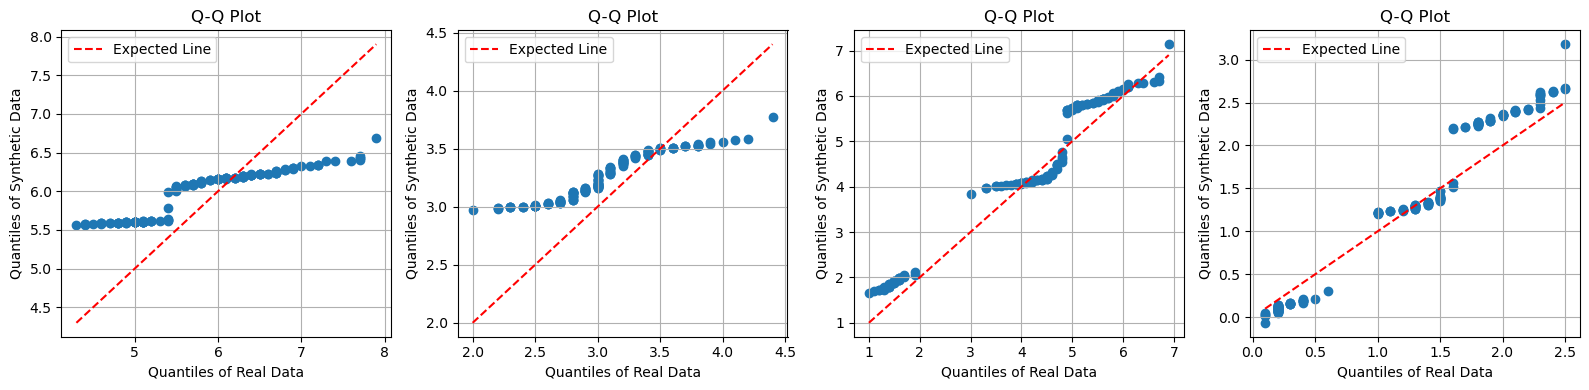

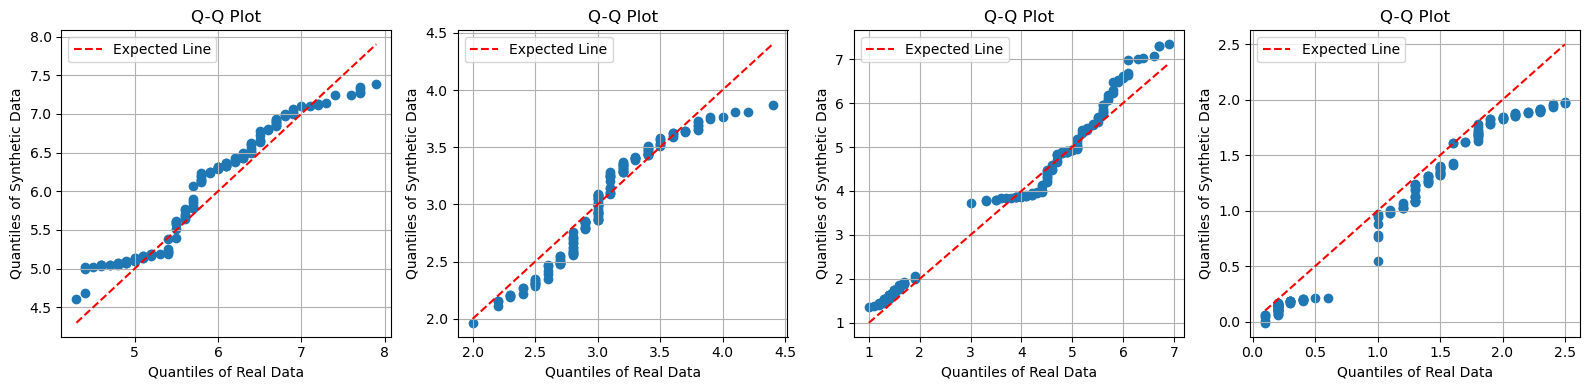

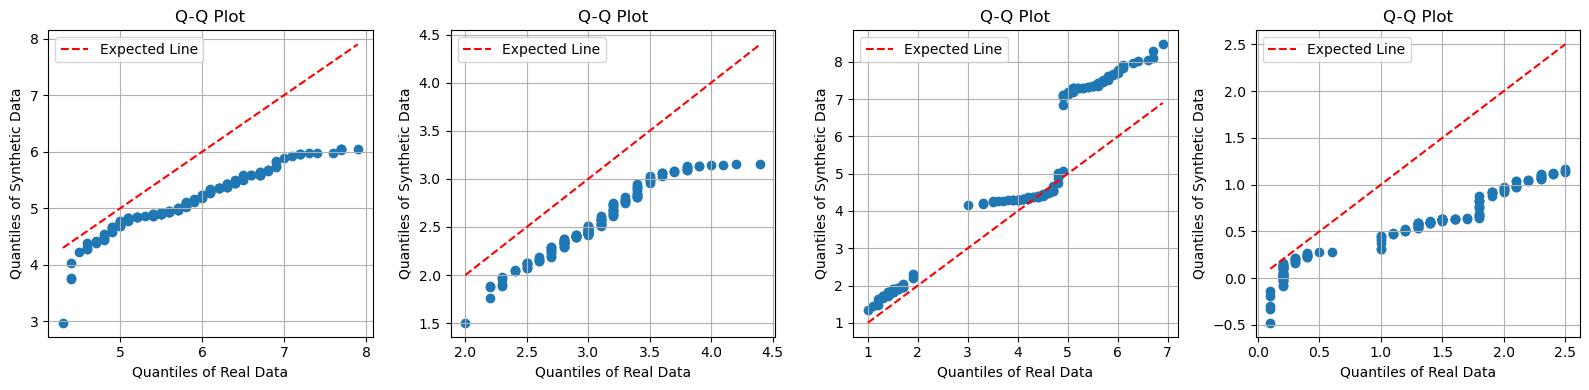

In [34]:
utils.plot_quantiles(real_iris, gan1_df)
utils.plot_quantiles(real_iris, gan2_df)
utils.plot_quantiles(real_iris, gan3_df)

In [35]:
print((real_iris.select_dtypes('number').corr().sum() - gan1_df.select_dtypes('number').corr().sum()).sum())
print((real_iris.select_dtypes('number').corr().sum() - gan2_df.select_dtypes('number').corr().sum()).sum())
print((real_iris.select_dtypes('number').corr().sum() - gan3_df.select_dtypes('number').corr().sum()).sum())

1.5207409003029546
0.36986108423335406
2.614073158863917


Overall, for the same noise vector size, it is the intermediate model that shows the best performance: in fact, it produces the smallest differences between the observed and recreated correlations, in the Q-Q graphs it can be seen that the two distributions tend to overlap more than in the other two models, and the reproduced univariate distributions also overlap more. 

We will continue with the fine-tuning of this architecture. But first we will look for the best dimension of the noise vector.

In [36]:
noise_size = [2**n for n in range(1, 10)]

noise_vector_model_dict = {'Noise Vector Size':[], 'Gen state dict': []}

for size_idx, size in enumerate(noise_size):
    
    set_seed()
    gen = Generator2(input_dim = size, num_classes = 3)
    disc = Discriminator2(input_dim = 4, num_classes = 3)
    
    g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
    d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

    criterion = nn.BCELoss()

    set_seed()
    z = torch.randn(150, size)
    
    for epoch in tqdm(range(501), desc = f'Training with {size} noise vector'):
    
        gen_epoch_loss = 0
        disc_epoch_loss = 0

        disc.train()
        gen.train()
        
        for data, labels in real_gan_dataloader:
            real_data = data
            real_labels = torch.ones(real_data.shape[0], 1)
            
            torch.seed()
            train_z = torch.randn(real_data.shape[0], size)
            fake_data = gen(train_z, labels)
            fake_labels = torch.zeros(real_data.shape[0], 1)
        
            disc.zero_grad()
            
            real_loss = criterion(disc(real_data, labels), real_labels)
            fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
            d_loss = (real_loss + fake_loss) / 2
            disc_epoch_loss += d_loss.item()
            d_loss.backward()
            
            d_opt.step()
        
            gen.zero_grad()

            gen_labels = torch.ones(real_data.shape[0], 1)

            g_loss = criterion(disc(fake_data, labels), gen_labels)
            gen_epoch_loss += g_loss.item()
            g_loss.backward()

            g_opt.step()
            
        g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
        d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
        
        if epoch % 100 == 0 or epoch == 500:
        
            print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
            with torch.no_grad():
                gen.eval()
                gen_z = gen(z, real_gan_dataloader.dataset.label)
                utils.compare_results(real_gan_dataloader.dataset.data, gen_z)
    
    noise_vector_model_dict['Noise Vector Size'].append(size)
    noise_vector_model_dict['Gen state dict'].append(gen.state_dict())

Training with 2 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6906 | GLoss 0.7111
MEAN: [-0.117  0.166 -0.026 -0.001]
STD:  [0.981 0.983 0.98  0.969]
MIN:  [-1.928 -2.22  -1.55  -1.395]
MAX:  [2.336 3.193 1.699 1.568]
SKEW: [ 0.854 -0.213 -0.779 -1.375]
KURT: [-0.25  -0.187 -1.043 -3.322]

Epoch 100/500 | DLoss: 0.5224 | GLoss 2.0414
MEAN: [-0.822  0.441 -0.537 -0.832]
STD:  [0.111 0.467 0.602 0.01 ]
MIN:  [-1.584 -1.373 -1.619 -1.293]
MAX:  [-0.182  2.604  0.492 -1.039]
SKEW: [ 0.009 -0.246 -0.388 -0.6  ]
KURT: [0.933 1.677 0.162 0.193]

Epoch 200/500 | DLoss: 0.6493 | GLoss 0.7392
MEAN: [-0.083  0.126  0.426  0.571]
STD:  [ 0.236 -0.091  0.012  0.057]
MIN:  [-0.806 -0.935  0.326  0.556]
MAX:  [1.427 1.549 1.115 1.376]
SKEW: [ 0.881 -0.309  0.236  0.527]
KURT: [0.865 1.6   0.073 0.13 ]

Epoch 300/500 | DLoss: 0.6710 | GLoss 0.7262
MEAN: [ 0.326  0.445 -0.067  0.226]
STD:  [0.346 0.53  0.119 0.008]
MIN:  [-0.616 -0.868 -0.526  0.136]
MAX:  [2.022 2.849 0.243 0.453]
SKEW: [ 0.692  0.597 -0.362  0.06 ]
KURT: [0.919 1.185 0.0

Training with 4 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6900 | GLoss 0.6688
MEAN: [0.134 0.058 0.027 0.244]
STD:  [0.979 0.983 0.992 0.983]
MIN:  [-1.683 -2.317 -1.507 -1.152]
MAX:  [2.528 3.103 1.791 1.919]
SKEW: [-0.33   0.281  0.452  0.257]
KURT: [-1.187  0.705 -1.771 -0.67 ]

Epoch 100/500 | DLoss: 0.2263 | GLoss 2.2866
MEAN: [ 0.359 -0.031  0.107  0.142]
STD:  [0.678 0.982 0.711 0.735]
MIN:  [-0.658 -2.382 -0.65  -0.531]
MAX:  [2.299 3.024 1.404 1.413]
SKEW: [0.536 1.689 0.082 0.336]
KURT: [ 0.226 -2.381 -0.817 -0.919]

Epoch 200/500 | DLoss: 0.4902 | GLoss 1.1258
MEAN: [-1.159 -1.371 -0.894 -0.413]
STD:  [0.255 0.078 0.172 0.131]
MIN:  [-2.143 -2.528 -1.308 -0.48 ]
MAX:  [-0.385 -0.885 -0.626  0.035]
SKEW: [-0.075 -0.204 -0.274  0.04 ]
KURT: [0.493 0.876 0.011 0.114]

Epoch 300/500 | DLoss: 0.4957 | GLoss 1.1603
MEAN: [-0.93  -0.373 -0.702  0.076]
STD:  [-0.368  0.683 -0.407  0.13 ]
MIN:  [-0.086 -2.307  0.737  0.986]
MAX:  [-0.213  1.926 -1.167  0.871]
SKEW: [0.888 0.044 0.112 0.755]
KURT: [ 0.789  1.683 -0.17

Training with 8 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6933 | GLoss 0.6449
MEAN: [0.174 0.098 0.168 0.275]
STD:  [0.969 0.967 0.96  0.982]
MIN:  [-1.617 -2.205 -1.232 -1.083]
MAX:  [2.549 3.126 1.873 1.946]
SKEW: [-0.413  0.814  0.528  0.818]
KURT: [-2.285  0.247 -2.155 -2.838]

Epoch 100/500 | DLoss: 0.5833 | GLoss 3.1568
MEAN: [ 0.432 -1.805  2.665  2.294]
STD:  [ 0.31  -0.609 -2.721 -0.831]
MIN:  [-0.252 -1.605  8.169  4.829]
MAX:  [ 1.191 -2.024 -3.087  1.526]
SKEW: [-0.052  0.301 -0.416  0.085]
KURT: [ 0.504  1.395 -0.165 -0.13 ]

Epoch 200/500 | DLoss: 0.6539 | GLoss 0.8269
MEAN: [ 0.754  0.485 -0.004  0.244]
STD:  [ 0.2   -0.097  0.125 -0.007]
MIN:  [ 0.102  0.296 -0.279  0.154]
MAX:  [ 1.745  2.208  0.061 -0.017]
SKEW: [-0.042  0.964  0.033 -0.183]
KURT: [ 0.812  1.38  -0.01   0.014]

Epoch 300/500 | DLoss: 0.6471 | GLoss 0.9864
MEAN: [-0.14   0.193 -0.668 -0.315]
STD:  [-0.177 -0.333 -0.29  -0.379]
MIN:  [-0.246  1.311 -0.247  0.128]
MAX:  [ 0.019  1.297 -1.445 -1.305]
SKEW: [ 0.032  0.935 -0.283 -0.376]
KU

Training with 16 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6905 | GLoss 0.7025
MEAN: [ 0.182  0.267 -0.217  0.197]
STD:  [0.981 0.968 0.98  0.986]
MIN:  [-1.622 -2.066 -1.702 -1.193]
MAX:  [2.618 3.285 1.512 1.855]
SKEW: [ 0.717  0.664 -0.185  0.299]
KURT: [-0.531  0.339 -1.563 -2.075]

Epoch 100/500 | DLoss: 0.4568 | GLoss 1.8394
MEAN: [-1.024  0.1   -0.686 -1.122]
STD:  [0.473 0.994 0.764 0.509]
MIN:  [-1.802 -2.304 -1.716 -1.531]
MAX:  [ 0.037  3.174  0.451 -0.736]
SKEW: [-0.052  1.135 -0.55  -0.527]
KURT: [-0.373 -0.346 -1.288 -1.195]

Epoch 200/500 | DLoss: 0.7249 | GLoss 1.2536
MEAN: [-0.389  0.14  -0.406  0.446]
STD:  [ 0.702  0.669  0.118 -0.493]
MIN:  [-1.921 -1.768 -0.472  1.575]
MAX:  [0.851 2.679 0.05  0.55 ]
SKEW: [-1.554  0.085  0.291  0.58 ]
KURT: [-4.371  1.653 -0.028  0.062]

Epoch 300/500 | DLoss: 0.6054 | GLoss 0.9678
MEAN: [ 0.036  0.198 -0.051 -0.455]
STD:  [ 0.442  0.041  0.185 -0.073]
MIN:  [-0.953  0.037 -0.289 -0.3  ]
MAX:  [ 1.643  1.901  0.807 -0.466]
SKEW: [0.637 0.443 0.318 0.282]
KURT: [0.8

Training with 32 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6906 | GLoss 0.7224
MEAN: [ 0.202  0.149 -0.041  0.198]
STD:  [0.981 0.984 0.971 0.988]
MIN:  [-1.616 -2.24  -1.541 -1.208]
MAX:  [2.623 3.192 1.645 1.865]
SKEW: [-0.061  0.489 -0.537 -0.194]
KURT: [-0.588  0.606 -1.556 -1.28 ]

Epoch 100/500 | DLoss: 0.2564 | GLoss 2.9571
MEAN: [0.446 1.702 0.324 0.529]
STD:  [0.887 0.115 0.753 0.795]
MIN:  [-1.081  2.014 -0.414 -0.221]
MAX:  [2.801 3.874 1.819 2.006]
SKEW: [1.175 1.309 0.646 0.875]
KURT: [-0.306  0.284 -1.397 -1.487]

Epoch 200/500 | DLoss: 0.6111 | GLoss 0.8090
MEAN: [ 0.029 -0.055 -0.243  0.111]
STD:  [ 0.461  0.296 -0.005  0.077]
MIN:  [-1.033 -0.469 -0.371 -0.012]
MAX:  [ 1.642e+00  2.120e+00 -2.000e-03  3.990e-01]
SKEW: [0.452 1.156 0.023 0.102]
KURT: [0.801 0.822 0.009 0.059]

Epoch 300/500 | DLoss: 0.6306 | GLoss 0.7412
MEAN: [-0.037 -0.075  0.201  0.008]
STD:  [ 0.243  0.301 -0.165  0.412]
MIN:  [-0.866 -0.617  0.381 -0.478]
MAX:  [ 0.97   1.954 -0.004  0.758]
SKEW: [ 0.014  0.746 -0.405  0.024]
KURT: 

Training with 64 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6901 | GLoss 0.6724
MEAN: [-0.21  -0.033 -0.225 -0.167]
STD:  [0.977 0.968 0.976 0.975]
MIN:  [-2.018 -2.374 -1.704 -1.524]
MAX:  [2.208 2.979 1.486 1.48 ]
SKEW: [-0.099  0.459 -0.331  0.319]
KURT: [-0.531  0.469 -1.777 -1.777]

Epoch 100/500 | DLoss: 0.4136 | GLoss 1.7700
MEAN: [-1.322 -0.572  0.019 -1.443]
STD:  [0.536 0.738 0.948 0.474]
MIN:  [-2.401 -2.568 -1.312 -1.995]
MAX:  [-0.207  1.65   1.721 -1.3  ]
SKEW: [-0.448 -0.484  0.711 -0.833]
KURT: [-0.662 -0.014 -2.699 -1.389]

Epoch 200/500 | DLoss: 0.3967 | GLoss 1.4073
MEAN: [0.585 0.589 0.187 0.596]
STD:  [0.179 0.238 0.301 0.268]
MIN:  [ 0.299 -0.314 -0.148  0.535]
MAX:  [2.008 1.998 0.999 1.475]
SKEW: [ 0.689 -0.283  0.023  0.388]
KURT: [ 0.748  1.002 -0.017 -0.006]

Epoch 300/500 | DLoss: 0.5825 | GLoss 0.7887
MEAN: [-0.072 -0.453 -0.157  0.272]
STD:  [ 0.374 -0.025  0.143  0.041]
MIN:  [-1.087 -1.805 -0.576  0.23 ]
MAX:  [1.337 0.848 0.116 0.71 ]
SKEW: [ 0.376 -0.408 -0.228  0.309]
KURT: [0.869 1.547

Training with 128 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6893 | GLoss 0.6752
MEAN: [ 0.112 -0.067 -0.211  0.043]
STD:  [0.983 0.975 0.983 0.977]
MIN:  [-1.71  -2.432 -1.717 -1.341]
MAX:  [2.527 2.962 1.521 1.682]
SKEW: [-0.06  0.22 -0.19 -0.24]
KURT: [-1.244  0.451 -1.458 -1.296]

Epoch 100/500 | DLoss: 0.5084 | GLoss 1.0420
MEAN: [-0.466  0.422 -0.595 -0.36 ]
STD:  [0.897 0.937 0.944 0.966]
MIN:  [-2.19  -1.82  -2.081 -1.747]
MAX:  [1.61  3.295 1.001 1.22 ]
SKEW: [-1.172 -0.148 -1.452 -1.206]
KURT: [-2.881 -0.411 -2.673 -2.377]

Epoch 200/500 | DLoss: 0.4715 | GLoss 2.0145
MEAN: [0.133 1.495 1.037 1.222]
STD:  [0.342 0.178 0.102 0.019]
MIN:  [-0.378  2.073  1.332  1.765]
MAX:  [1.348 3.379 1.578 1.586]
SKEW: [0.603 1.133 0.225 0.391]
KURT: [ 0.603 -0.258 -0.12  -0.062]

Epoch 300/500 | DLoss: 0.6378 | GLoss 0.7916
MEAN: [ 0.07  -0.029 -0.454  0.366]
STD:  [ 0.519  0.45  -0.074 -0.054]
MIN:  [-1.017 -1.585 -0.366  0.57 ]
MAX:  [ 1.55   2.017 -0.589  0.5  ]
SKEW: [ 0.163 -0.073 -0.184  0.031]
KURT: [ 0.658  1.345 -0.06

Training with 256 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6917 | GLoss 0.6580
MEAN: [-0.028  0.273  0.063  0.196]
STD:  [0.983 0.984 0.97  0.976]
MIN:  [-1.841 -2.116 -1.42  -1.181]
MAX:  [2.408 3.309 1.772 1.83 ]
SKEW: [ 0.396  0.431 -0.024 -0.407]
KURT: [-0.704  0.465 -1.046 -1.212]

Epoch 100/500 | DLoss: 0.4070 | GLoss 1.8080
MEAN: [-0.758 -0.032 -0.58  -0.532]
STD:  [-0.106  0.737  0.365  0.279]
MIN:  [-1.712 -2.185 -1.628 -1.388]
MAX:  [-2.144  2.164 -1.004 -1.436]
SKEW: [-1.024 -0.998 -1.611 -1.531]
KURT: [-1.372 -0.53  -2.182 -2.454]

Epoch 200/500 | DLoss: 0.6721 | GLoss 0.7353
MEAN: [-0.338  0.417  0.078  0.062]
STD:  [0.313 0.159 0.081 0.055]
MIN:  [-1.03  -0.587  0.217  0.383]
MAX:  [0.767 1.913 0.835 0.579]
SKEW: [ 0.692 -0.272  0.455  0.512]
KURT: [ 0.662  1.423 -0.156 -0.005]

Epoch 300/500 | DLoss: 0.6855 | GLoss 0.7110
MEAN: [-0.036 -0.263  0.027  0.081]
STD:  [ 0.327  0.319  0.001 -0.07 ]
MIN:  [-8.250e-01 -2.153e+00 -1.000e-03  2.270e-01]
MAX:  [1.501 1.516 0.454 0.279]
SKEW: [ 0.649 -0.495  0.175  0

Training with 512 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6895 | GLoss 0.7006
MEAN: [ 0.08  -0.123  0.13   0.163]
STD:  [0.992 0.982 0.988 0.976]
MIN:  [-1.76  -2.482 -1.383 -1.22 ]
MAX:  [2.545 2.926 1.894 1.799]
SKEW: [ 0.389  0.919  0.811 -0.034]
KURT: [-0.302 -0.454 -2.822 -1.231]

Epoch 100/500 | DLoss: 0.2754 | GLoss 2.9162
MEAN: [ 2.354  1.076 -0.91  -3.234]
STD:  [-0.343  0.255  0.52  -0.675]
MIN:  [ 5.073  1.204 -1.748 -2.031]
MAX:  [ 2.776  2.982 -0.757 -7.055]
SKEW: [ 1.393  1.353 -1.266 -1.163]
KURT: [-1.538 -0.657 -2.051 -2.257]

Epoch 200/500 | DLoss: 0.5768 | GLoss 2.0539
MEAN: [-0.974  0.13  -0.924 -1.333]
STD:  [-0.263  0.339  0.689  0.127]
MIN:  [ 0.837  0.238 -1.875 -1.227]
MAX:  [-0.35   2.648  0.082 -1.218]
SKEW: [ 1.318  2.128 -0.313  0.148]
KURT: [-0.674 -2.455 -0.813 -0.172]

Epoch 300/500 | DLoss: 0.2911 | GLoss 3.1097
MEAN: [ 0.151  0.452  0.739 -0.557]
STD:  [0.067 0.687 0.336 0.515]
MIN:  [ 0.079 -0.887  0.533 -1.334]
MAX:  [ 1.145  2.98   1.527 -0.294]
SKEW: [ 0.693  1.222  0.041 -0.811]
KU

In [37]:
noise_vector_model_dict

{'Noise Vector Size': [2, 4, 8, 16, 32, 64, 128, 256, 512],
 'Gen state dict': [OrderedDict([('label_emb.weight',
                tensor([[ 1.7461e+00, -3.3669e-01, -2.1801e+00],
                        [ 8.6806e-02, -1.0255e+00, -1.0253e+00],
                        [ 2.1235e-04,  8.6002e-01, -4.1099e-01]])),
               ('model.0.weight',
                tensor([[ 0.2255,  0.3273, -0.1051,  0.3002, -0.0826],
                        [-0.0769,  0.1916, -0.4025, -0.3407, -0.1018],
                        [-0.2016,  0.1662, -0.4318, -0.0112, -0.0972],
                        [-0.2281, -0.2124,  0.3046,  0.3062,  0.3158],
                        [ 0.0071, -0.1163,  0.1759, -0.0792, -0.2826],
                        [-0.2115,  0.1332,  0.1466, -0.0442,  0.1674],
                        [ 0.4014,  0.3803,  0.0234,  0.1296,  0.3755],
                        [-0.1149, -0.0679, -0.5081, -0.3085, -0.0613],
                        [ 0.3617,  0.2040, -0.0182,  0.1180,  0.0153],
               